# DS 6021 Final Project: An Analysis of Obesity Levels from Nutrition and Physical Characteristics

Bela Barton, Ben Doniger, Emily Garman, Natalie Seah, & Erin Siedlecki

## Introduction & Dataset Summary

For this analysis, we are using the "Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico" from Fabio Mendoza Palechor and Alexis de la Hoz Manotas. These researchers investigated obesity levels of individuals in a few countries based on factors related to eating habits, physical condition, and lifestyle attributes. Specifically, they explored features such as family history, age, gender, daily meals, water and alcohol intake, exercise, and transportation. The response variable is the Obesity Level, one of seven classifications: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, and Obesity Type III. We then manually calculated BMI using the height and weight columns of the dataset to create a numeric response variable as well. 

The data was originally collected via an anonymous online survey. The researchers obtained 485 records, preprocessed the data, computed the individual's BMI, and then labeled the obesity level based on information from the WHO and Mexican Normativity. After this, they discovered a balance issue where the number of records resulting in a "Normal" classification was significantly higher than the others, which would become problematic in classification models. To resolve this, they generated synthetic data, resulting in the final, balanced dataset containing 2,111 records.

In [22]:
# Link to paper:
# https://www.sciencedirect.com/science/article/pii/S2352340919306985?ref=pdf_download&fr=RR-2&rr=9a76ef980c9b151c

## Citation

Estimation of Obesity Levels Based On Eating Habits and Physical Condition  [Dataset]. (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5H31Z.

In [23]:
# Add research Qs

## Data Engineering & Preparation

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

#### The Data Cleaning / Data Engineering (raw) Code

#### The Data Cleaning / Data Engineering Process

The dataset was loaded with pandas and initially checked using .info(). All columns were complete with no missing values, which made the cleaning process more straightforward. Before making any transformations, the official [dataset article](https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub) was consulted to understand what each variable represented according to the codebook.

The first step was renaming several columns to make them more readable. Many of the original names were short codes (like FAVC, FCVC, or NCP), so they were converted into descriptive labels that matched the codebook definitions. This made the dataset much easier and more intuitive to work with later.

Next, all binary categorical variables were standardized by mapping "yes"/"no" to "Yes"/"No" for consistency. This applied to features such as family history of overweight, high-calorie food consumption, smoking habits, and daily calorie monitoring.

Some features, like vegetable consumption frequency, number of daily meals, water intake, workout frequency, and time spent using technology, contained decimal values, even though the codebook defined them as categorical scales. Because the decimals didn’t carry meaningful information and the underlying scales were discrete, these variables were rounded to the nearest integer. This made sure the values aligned as accurately as possible with the categories defined in the codebook. 

After rounding, each integer was mapped to its proper label (for example, turning a 1 into “Never” for vegetable consumption or “Less than a liter” for water intake). Additional inconsistencies in text values were also corrected, such as fixing "Public_Transportation" and expanding the obesity-level categories into more readable forms (like "Obesity_Type_I" → "Obesity Type I").

Finally, all categorical features were converted to the category dtype so they are stored efficiently and treated properly during modeling. The cleaned dataset was exported as obesity_cleaned.csv, which is the version used for the rest of the project.

In [25]:
df = pd.read_csv('obesity_cleaned.csv')

In [ ]:
df['BMI_kg_m2'] = round(df['Weight'] / (df['Height'] ** 2),2)

In [27]:
df.head(5)

Gender   Age  Height  Weight Overweight_Family_History  \
0  Female  21.0    1.62    64.0                       Yes   
1  Female  21.0    1.52    56.0                       Yes   
2    Male  23.0    1.80    77.0                       Yes   
3    Male  27.0    1.80    87.0                        No   
4    Male  22.0    1.78    89.8                        No   

  High_Calorie_Consumption_Often Vegetable_Consumption_Often  \
0                             No                   Sometimes   
1                             No                      Always   
2                             No                   Sometimes   
3                             No                      Always   
4                             No                   Sometimes   

   Num_Main_Meals_Daily Eat_Between_Meals Smoke_Regularly  \
0                     3         Sometimes              No   
1                     3         Sometimes             Yes   
2                     3         Sometimes              No   
3                     3         Sometimes              No   
4                     1         Sometimes              No   

        Water_Drank_Daily Calories_Monitored_Daily   Workout_Frequency  \
0  Between 1 and 2 liters                       No   I do not exercise   
1      More than 2 liters                      Yes  4 to 5 days a week   
2  Between 1 and 2 liters                       No  3 to 4 days a week   
3  Between 1 and 2 liters                       No  3 to 4 days a week   
4  Between 1 and 2 liters                       No   I do not exercise   

  Time_Using_Technology_Daily Alcohol_Consumption_Frequency  \
0                   3-5 hours                         Never   
1                   0-2 hours                     Sometimes   
2                   3-5 hours                    Frequently   
3                   0-2 hours                    Frequently   
4                   0-2 hours                     Sometimes   

  Means_of_Transportation        Obesity_Level  BMI (kg/m2)  
0   Public Transportation        Normal Weight        24.39  
1   Public Transportation        Normal Weight        24.24  
2   Public Transportation        Normal Weight        23.77  
3                 Walking   Overweight Level I        26.85  
4   Public Transportation  Overweight Level II        28.34

In [ ]:
df = df.rename(columns={
    'Height': 'Height_meters',
    'Weight': 'Weight_kg',
    'BMI_kg_m2': 'BMI_kg_m2'
})
df.head(5)

Gender   Age  Height_meters  Weight_kg Overweight_Family_History  \
0  Female  21.0           1.62       64.0                       Yes   
1  Female  21.0           1.52       56.0                       Yes   
2    Male  23.0           1.80       77.0                       Yes   
3    Male  27.0           1.80       87.0                        No   
4    Male  22.0           1.78       89.8                        No   

  High_Calorie_Consumption_Often Vegetable_Consumption_Often  \
0                             No                   Sometimes   
1                             No                      Always   
2                             No                   Sometimes   
3                             No                      Always   
4                             No                   Sometimes   

   Num_Main_Meals_Daily Eat_Between_Meals Smoke_Regularly  \
0                     3         Sometimes              No   
1                     3         Sometimes             Yes   
2                     3         Sometimes              No   
3                     3         Sometimes              No   
4                     1         Sometimes              No   

        Water_Drank_Daily Calories_Monitored_Daily   Workout_Frequency  \
0  Between 1 and 2 liters                       No   I do not exercise   
1      More than 2 liters                      Yes  4 to 5 days a week   
2  Between 1 and 2 liters                       No  3 to 4 days a week   
3  Between 1 and 2 liters                       No  3 to 4 days a week   
4  Between 1 and 2 liters                       No   I do not exercise   

  Time_Using_Technology_Daily Alcohol_Consumption_Frequency  \
0                   3-5 hours                         Never   
1                   0-2 hours                     Sometimes   
2                   3-5 hours                    Frequently   
3                   0-2 hours                    Frequently   
4                   0-2 hours                     Sometimes   

  Means_of_Transportation        Obesity_Level  BMI_kg_m2  
0   Public Transportation        Normal Weight      24.39  
1   Public Transportation        Normal Weight      24.24  
2   Public Transportation        Normal Weight      23.77  
3                 Walking   Overweight Level I      26.85  
4   Public Transportation  Overweight Level II      28.34

## Visualization & Exploratory Data Analysis

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height_meters                   2111 non-null   float64
 3   Weight_kg                       2111 non-null   float64
 4   Overweight_Family_History       2111 non-null   object 
 5   High_Calorie_Consumption_Often  2111 non-null   object 
 6   Vegetable_Consumption_Often     2111 non-null   object 
 7   Num_Main_Meals_Daily            2111 non-null   int64  
 8   Eat_Between_Meals               2111 non-null   object 
 9   Smoke_Regularly                 2111 non-null   object 
 10  Water_Drank_Daily               2111 non-null   object 
 11  Calories_Monitored_Daily        2111 non-null   object 
 12  Workout_Frequency               21

In [30]:
numeric = df[['Age', 'Height_meters', 'Weight_kg', 'Num_Main_Meals_Daily', 'BMI_kg_m2']]
num_corr = numeric.corr()
num_corr

Age  Height_meters  Weight_kg  \
Age                   1.000000      -0.025958   0.202560   
Height_meters        -0.025958       1.000000   0.463136   
Weight_kg             0.202560       0.463136   1.000000   
Num_Main_Meals_Daily -0.043367       0.244055   0.103273   
BMI_kg_m2             0.244149       0.131788   0.934807   

                      Num_Main_Meals_Daily  BMI_kg_m2  
Age                              -0.043367   0.244149  
Height_meters                     0.244055   0.131788  
Weight_kg                         0.103273   0.934807  
Num_Main_Meals_Daily              1.000000   0.033819  
BMI_kg_m2                         0.033819   1.000000

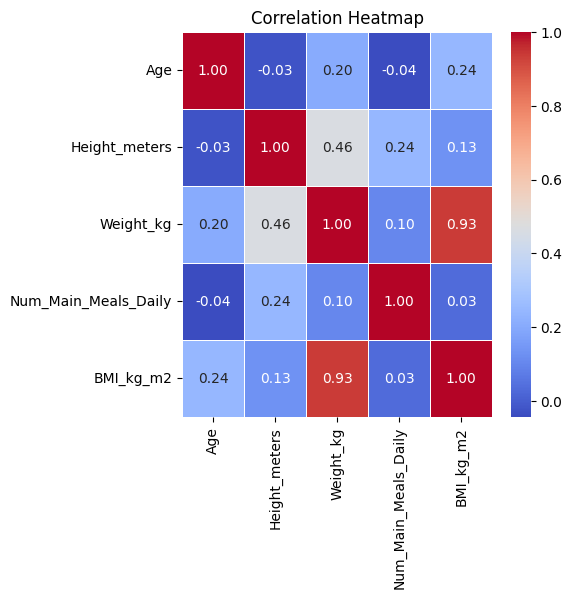

In [31]:
plt.figure(figsize=(5, 5))
sns.heatmap(num_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

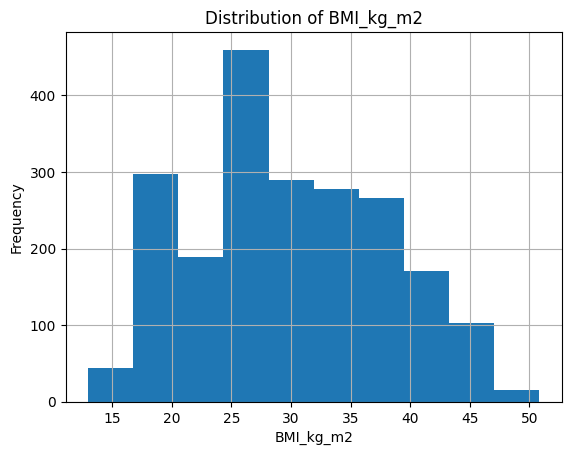

In [32]:
df['BMI_kg_m2'].hist()
plt.title('Distribution of BMI_kg_m2')
plt.xlabel('BMI_kg_m2')
plt.ylabel('Frequency')
plt.show()

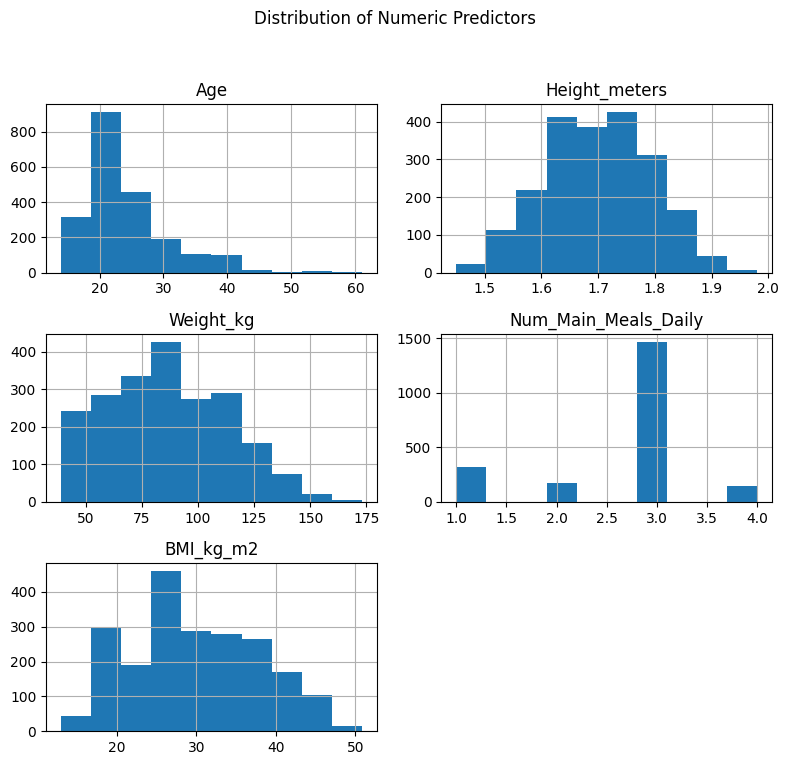

In [33]:
numeric.hist(figsize=(8,8))
plt.suptitle('Distribution of Numeric Predictors')
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

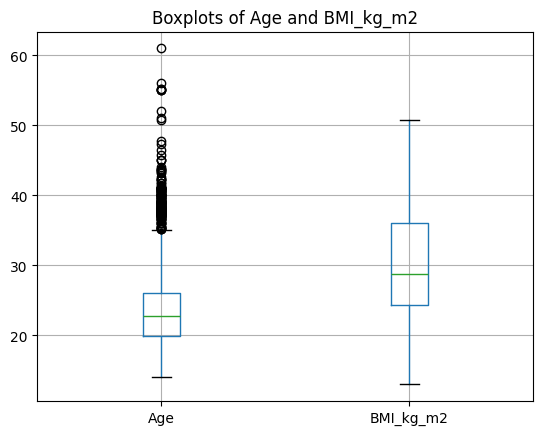

In [34]:
df[['Age', 'BMI_kg_m2']].boxplot()
plt.title('Boxplots of Age and BMI_kg_m2')
plt.show()

In [ ]:
df['Weight_kg'].plot.box()
plt.title('Boxplot of Weight_kg')
plt.show()

KeyError: 'Weight (kg)'

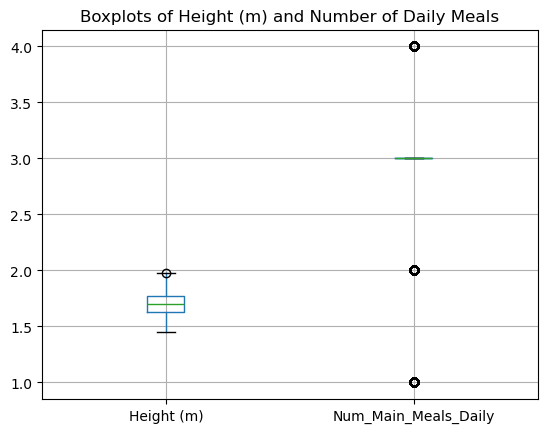

In [ ]:
df[['Height_meters', 'Num_Main_Meals_Daily']].boxplot()
plt.title('Boxplots of Height_meters and Number of Daily Meals')
plt.show()

In [ ]:
df.describe()

Age   Height (m)  Weight (kg)  Num_Main_Meals_Daily  \
count  2111.000000  2111.000000  2111.000000           2111.000000   
mean     24.312600     1.701677    86.586058              2.687826   
std       6.345968     0.093305    26.191172              0.809680   
min      14.000000     1.450000    39.000000              1.000000   
25%      19.947192     1.630000    65.473343              3.000000   
50%      22.777890     1.700499    83.000000              3.000000   
75%      26.000000     1.768464   107.430682              3.000000   
max      61.000000     1.980000   173.000000              4.000000   

       BMI (kg/m2)  
count  2111.000000  
mean     29.700137  
std       8.011354  
min      13.000000  
25%      24.325000  
50%      28.720000  
75%      36.015000  
max      50.810000

In [ ]:
df.describe(include='all')

Gender          Age   Height (m)  Weight (kg)  \
count    2111  2111.000000  2111.000000  2111.000000   
unique      2          NaN          NaN          NaN   
top      Male          NaN          NaN          NaN   
freq     1068          NaN          NaN          NaN   
mean      NaN    24.312600     1.701677    86.586058   
std       NaN     6.345968     0.093305    26.191172   
min       NaN    14.000000     1.450000    39.000000   
25%       NaN    19.947192     1.630000    65.473343   
50%       NaN    22.777890     1.700499    83.000000   
75%       NaN    26.000000     1.768464   107.430682   
max       NaN    61.000000     1.980000   173.000000   

       Overweight_Family_History High_Calorie_Consumption_Often  \
count                       2111                           2111   
unique                         2                              2   
top                          Yes                            Yes   
freq                        1726                           1866   
mean                         NaN                            NaN   
std                          NaN                            NaN   
min                          NaN                            NaN   
25%                          NaN                            NaN   
50%                          NaN                            NaN   
75%                          NaN                            NaN   
max                          NaN                            NaN   

       Vegetable_Consumption_Often  Num_Main_Meals_Daily Eat_Between_Meals  \
count                         2111           2111.000000              2111   
unique                           3                   NaN                 4   
top                      Sometimes                   NaN         Sometimes   
freq                          1013                   NaN              1765   
mean                           NaN              2.687826               NaN   
std                            NaN              0.809680               NaN   
min                            NaN              1.000000               NaN   
25%                            NaN              3.000000               NaN   
50%                            NaN              3.000000               NaN   
75%                            NaN              3.000000               NaN   
max                            NaN              4.000000               NaN   

       Smoke_Regularly       Water_Drank_Daily Calories_Monitored_Daily  \
count             2111                    2111                     2111   
unique               2                       3                        2   
top                 No  Between 1 and 2 liters                       No   
freq              2067                    1110                     2015   
mean               NaN                     NaN                      NaN   
std                NaN                     NaN                      NaN   
min                NaN                     NaN                      NaN   
25%                NaN                     NaN                      NaN   
50%                NaN                     NaN                      NaN   
75%                NaN                     NaN                      NaN   
max                NaN                     NaN                      NaN   

         Workout_Frequency Time_Using_Technology_Daily  \
count                 2111                        2111   
unique                   4                           3   
top     1 or 2 days a week                   0-2 hours   
freq                   776                         952   
mean                   NaN                         NaN   
std                    NaN                         NaN   
min                    NaN                         NaN   
25%                    NaN                         NaN   
50%                    NaN                         NaN   
75%                    NaN                         NaN   
max                    NaN                         Na

In [ ]:
categorical = df.select_dtypes(include='object').columns

for col in categorical:
    print(df[col].value_counts())
    print('-' * 30)

Gender
Male      1068
Female    1043
Name: count, dtype: int64
------------------------------
Overweight_Family_History
Yes    1726
No      385
Name: count, dtype: int64
------------------------------
High_Calorie_Consumption_Often
Yes    1866
No      245
Name: count, dtype: int64
------------------------------
Vegetable_Consumption_Often
Sometimes    1013
Always        996
Never         102
Name: count, dtype: int64
------------------------------
Eat_Between_Meals
Sometimes     1765
Frequently     242
Always          53
Never           51
Name: count, dtype: int64
------------------------------
Smoke_Regularly
No     2067
Yes      44
Name: count, dtype: int64
------------------------------
Water_Drank_Daily
Between 1 and 2 liters    1110
More than 2 liters         516
Less than a liter          485
Name: count, dtype: int64
------------------------------
Calories_Monitored_Daily
No     2015
Yes      96
Name: count, dtype: int64
------------------------------
Workout_Frequency
1 or 2 d

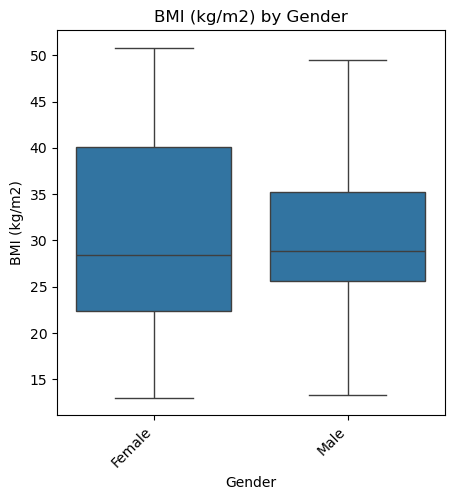

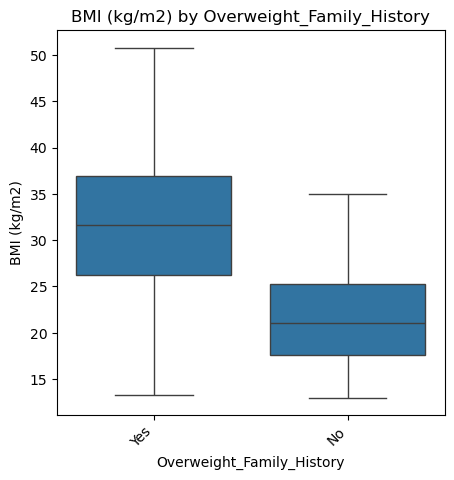

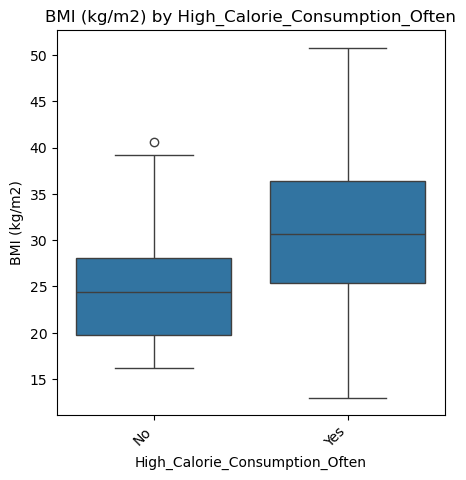

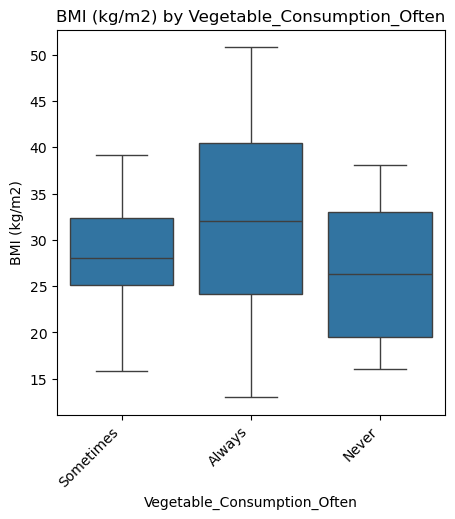

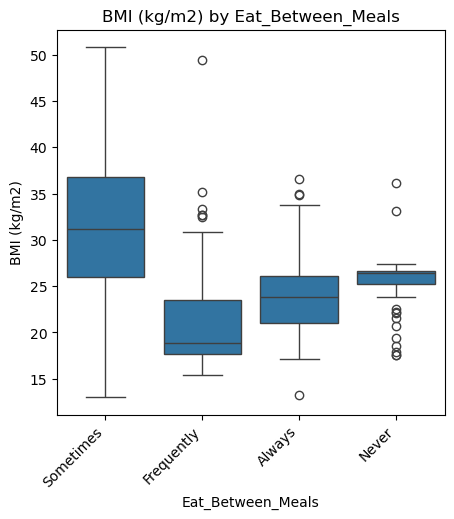

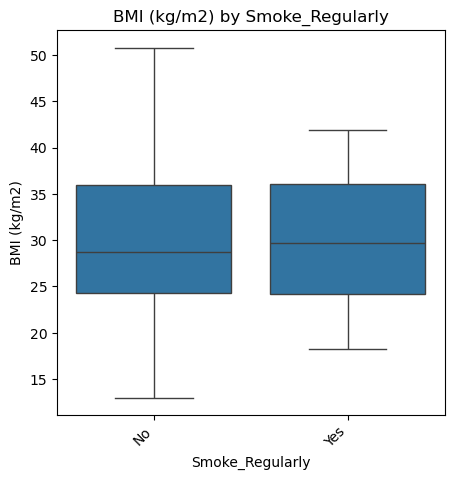

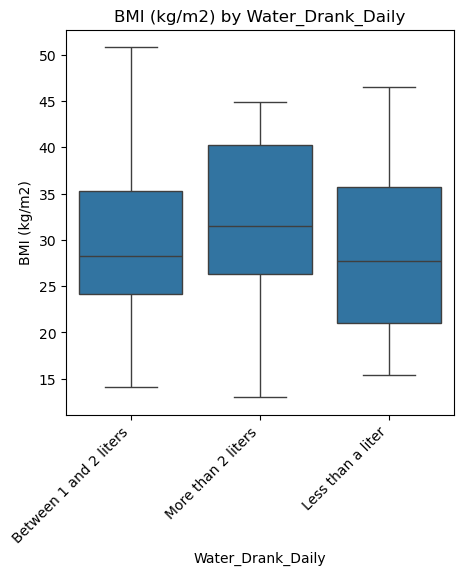

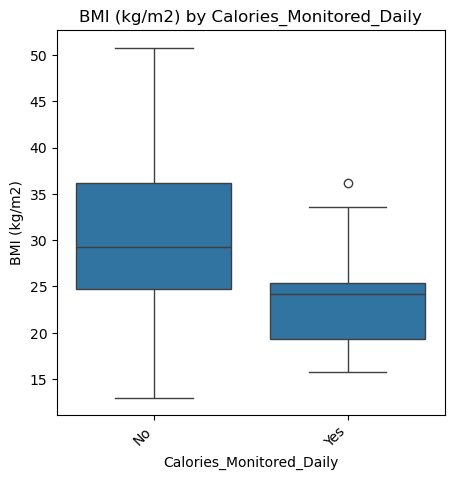

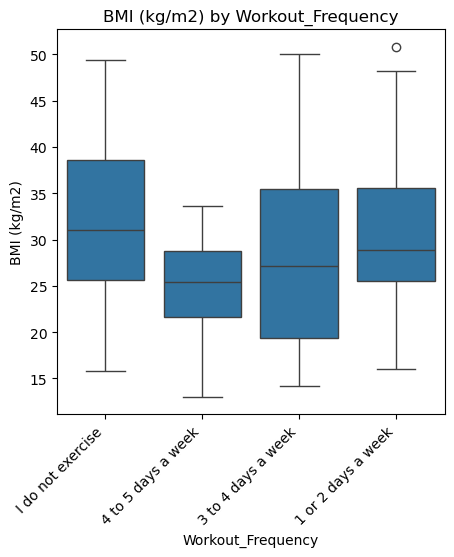

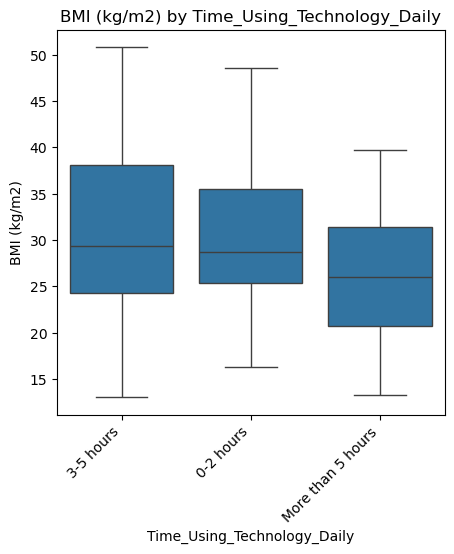

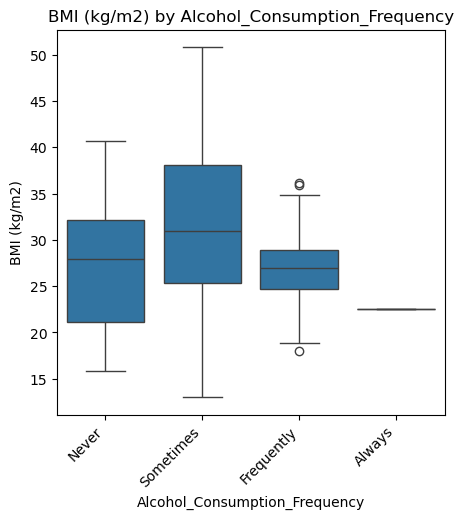

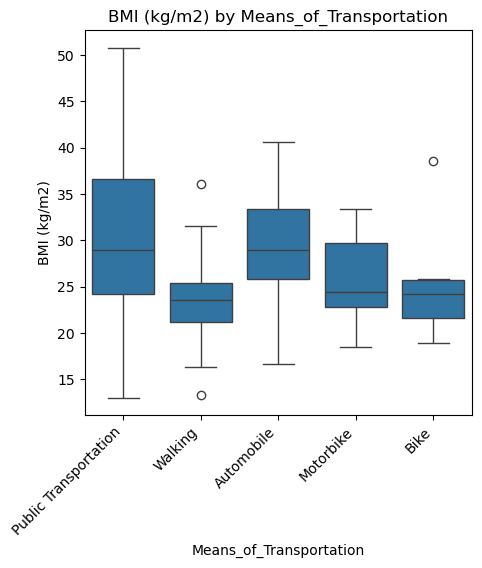

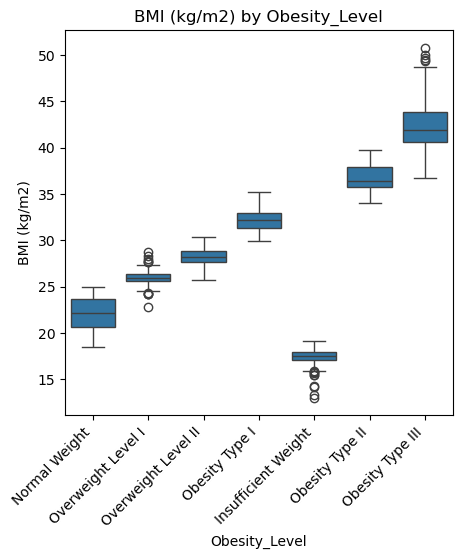

In [ ]:
for col in categorical:
    plt.figure(figsize=(5,5))
    sns.boxplot(x=col, y='BMI_kg_m2', data=df)
    plt.title(f'BMI_kg_m2 by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

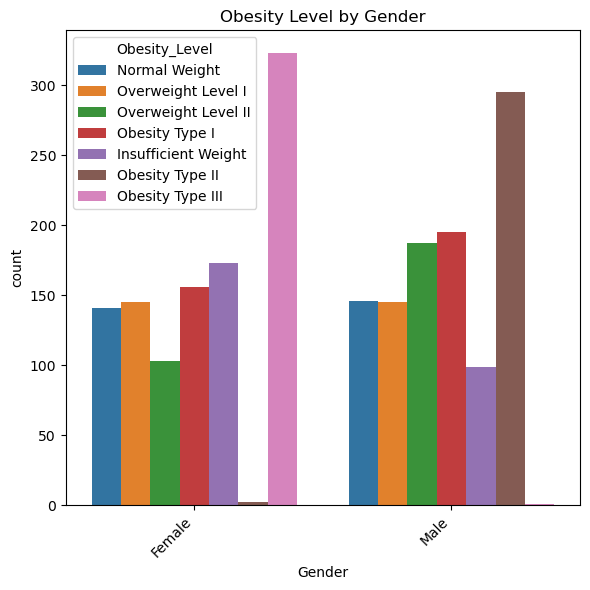

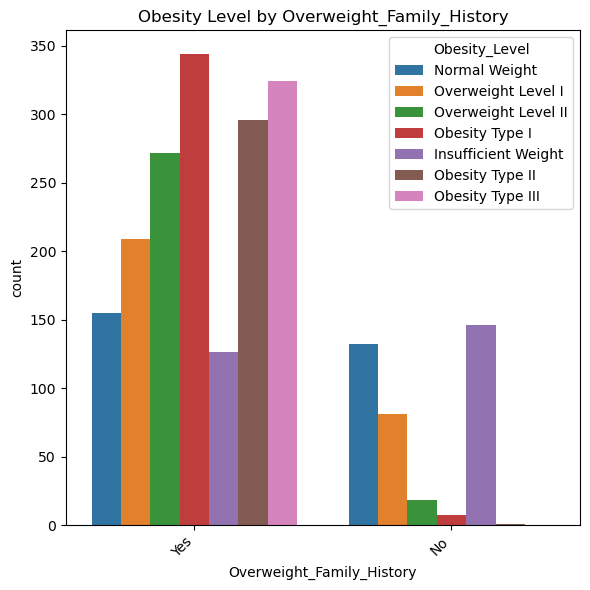

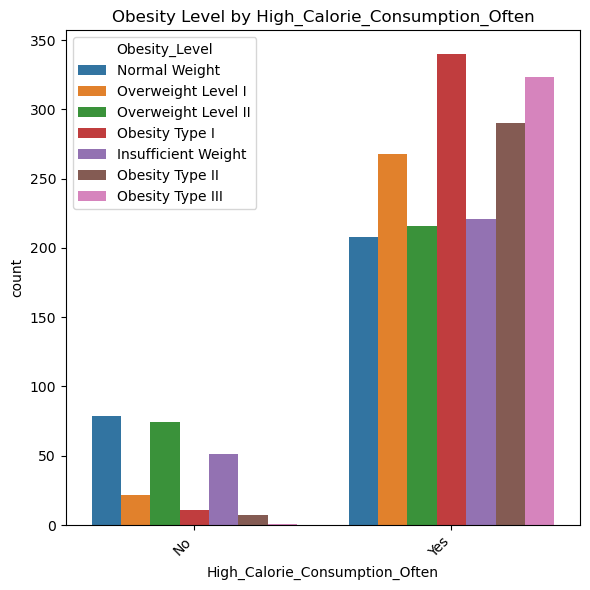

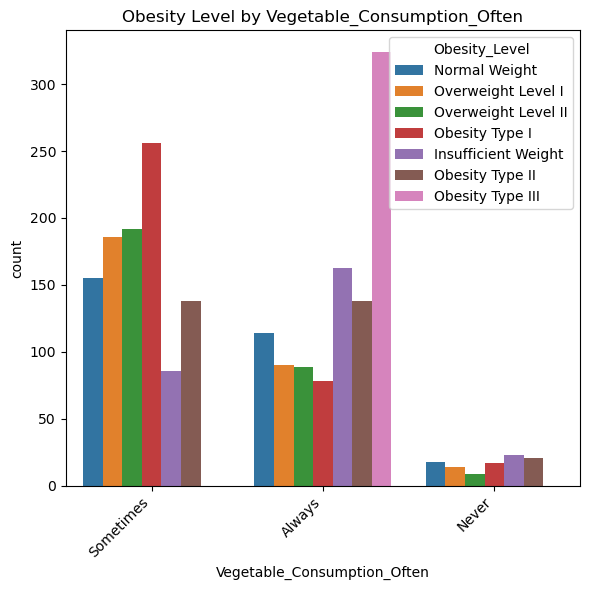

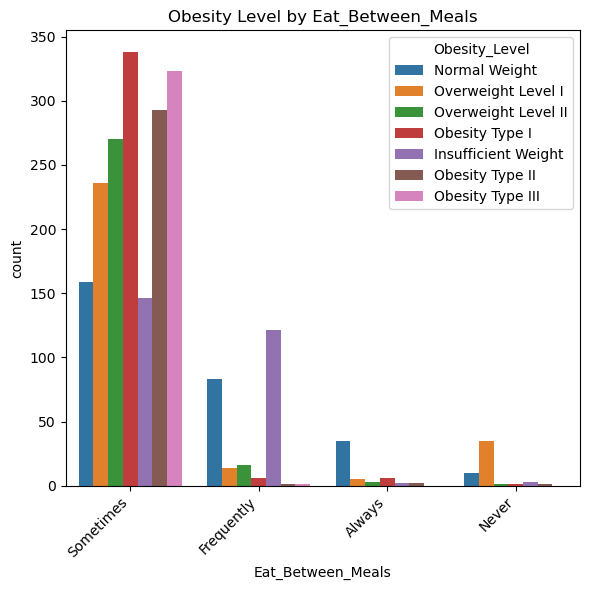

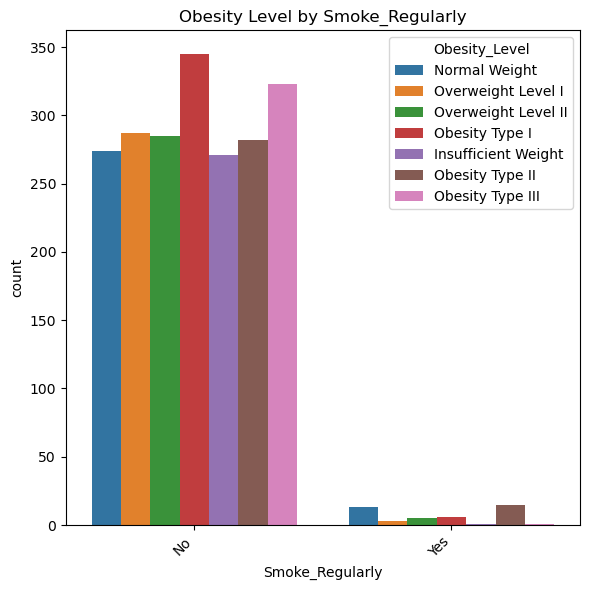

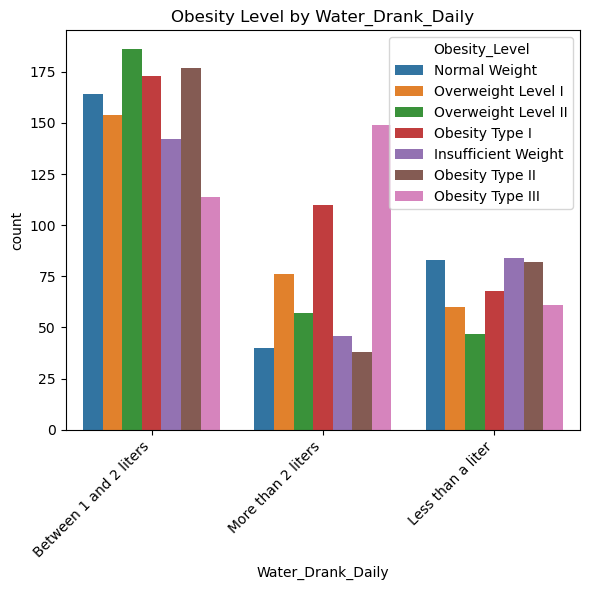

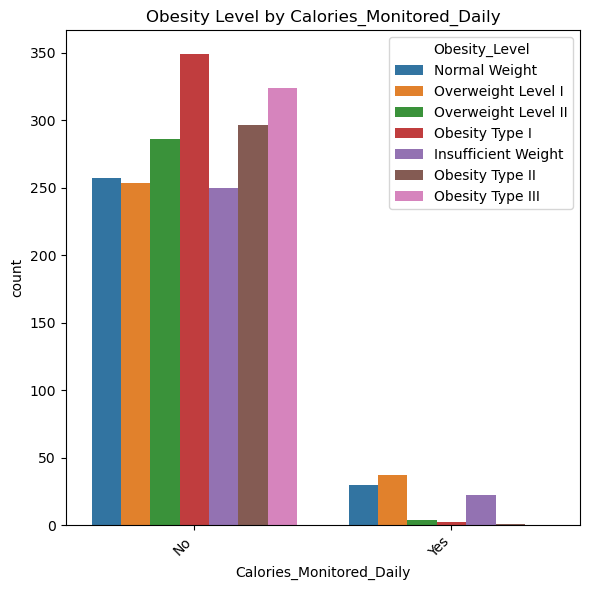

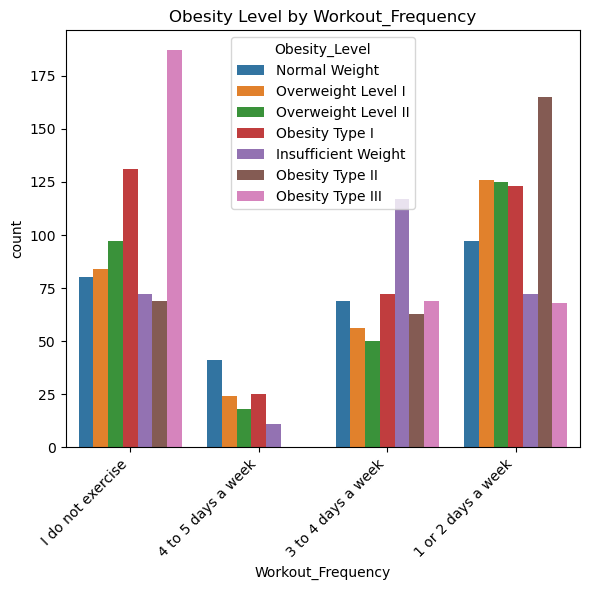

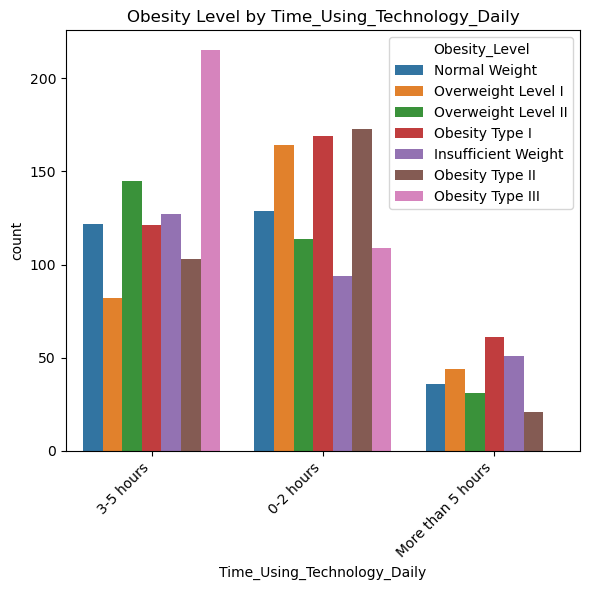

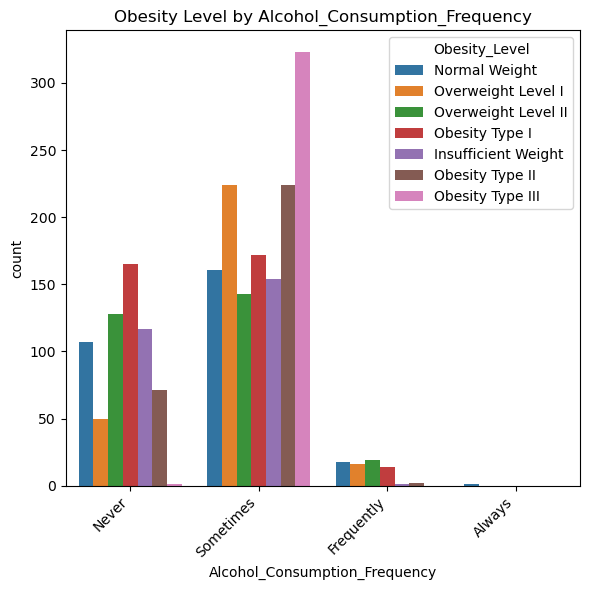

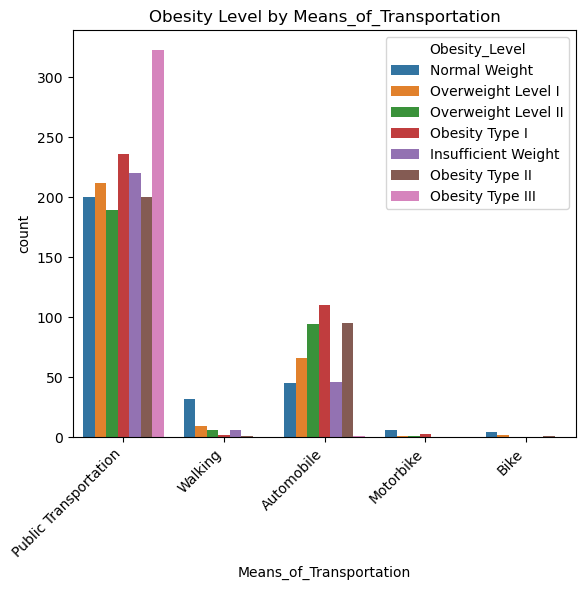

In [ ]:
cat2 = categorical.drop('Obesity_Level')
for col in cat2:
    plt.figure(figsize=(6,6))
    sns.countplot(x=col, hue='Obesity_Level', data=df)
    plt.title(f'Obesity Level by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Model 1: Multiple Regression

Which eating habits, lifestyle factors, and physical activity factors are most predictive of BMI?

In [ ]:
df['Alcohol_Consumption_Frequency'].value_counts()

Alcohol_Consumption_Frequency
Sometimes     1401
Never          639
Frequently      70
Always           1
Name: count, dtype: int64

Based on our EDA, there seems to be a major class imbalance between the different levels of our Alcohol_Consumption_Frequency variable, the "Always" category only has 1 observation, so we will just remove it.

In [ ]:
df= df[df['Alcohol_Consumption_Frequency'] != 'Always']

In [ ]:
target = 'BMI_kg_m2'
nums = ['Age']
cats = [
    'Overweight_Family_History',
    'High_Calorie_Consumption_Often',
    'Vegetable_Consumption_Often',
    'Calories_Monitored_Daily',
    'Workout_Frequency',
    'Alcohol_Consumption_Frequency',
    'Means_of_Transportation'
]

X = df[nums + cats]
y = df[target]

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset indices so X and y align
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("encoder", OneHotEncoder(drop="first"), cats),
        ("numeric", "passthrough", nums)
    ]
)

X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

X_train_sm = sm.add_constant(X_train_df)
model = sm.OLS(y_train, X_train_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            BMI (kg/m2)   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     87.36
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          2.01e-197
Time:                        19:45:05   Log-Likelihood:                -5411.3
No. Observations:                1688   AIC:                         1.085e+04
Df Residuals:                    1672   BIC:                         1.094e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

The p-value of the overall F-test was highly significant, indicating that the regression model explains a significant portion of the variability in BMI.

In [ ]:
X_test_sm = sm.add_constant(X_test_df)
y_pred = model.predict(X_test_sm)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR² = {r2:.3f}, RMSE = {rmse:.3f}")


R² = 0.350, RMSE = 6.573


## Check Assumptions (Multiple Regression)

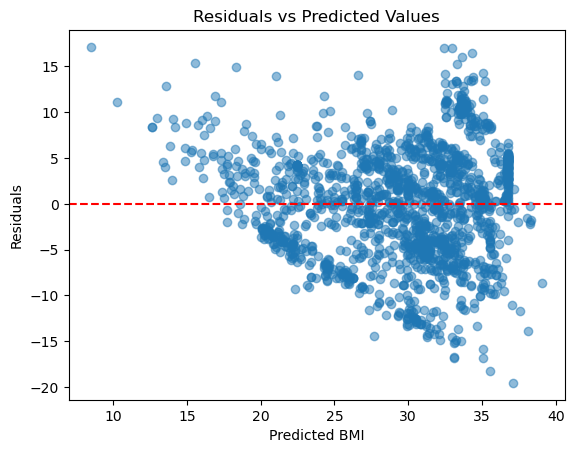

In [ ]:
y_pred = model.fittedvalues
residuals = model.resid

# Residuals vs predicted
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted BMI")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

1. Linearity: The residuals are not randomly scattered around 0, as there is a clear pattern, indicating that the linearity assumption has been violated. 

2. Independence: Because the Durbin–Watson statistic was 2.111, very close to 2, the independence assumption is satisfied.

3. Constant variance of errors: There is a clear pattern when the residuals are plotted, so this assumption is violated. I will try transforming the response variable.

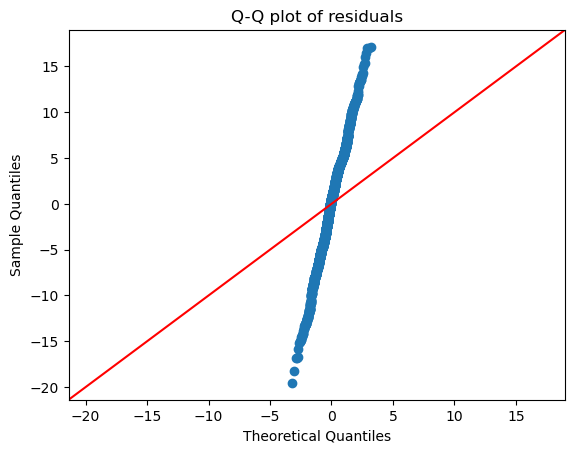

In [ ]:
sm.qqplot(residuals, line='45')
plt.title("Q-Q plot of residuals")
plt.show()

Text(0, 0.5, 'Frequency')

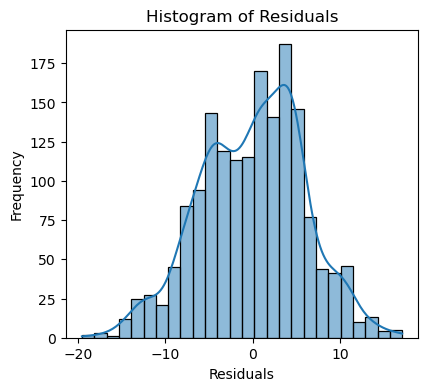

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

4. Normality assumption: the qqplot of the residuals were a straight line, but deviated from the red theoretical normal line, so I created a histogram of the residuals to further check the normality assumption. The histogram appears to be roughly symmetric and bell shaped around 0, so the normality assumption is met. 

In [ ]:
X_df = pd.DataFrame(model.model.exog, columns=model.model.exog_names)

vif = pd.DataFrame()
vif['Variable'] = X_df.columns
vif['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
print(vif)

                                             Variable        VIF
0                                               const  93.527943
1              encoder__Overweight_Family_History_Yes   1.131661
2         encoder__High_Calorie_Consumption_Often_Yes   1.150136
3          encoder__Vegetable_Consumption_Often_Never   1.066867
4      encoder__Vegetable_Consumption_Often_Sometimes   1.083732
5               encoder__Calories_Monitored_Daily_Yes   1.097210
6       encoder__Workout_Frequency_3 to 4 days a week   1.306901
7       encoder__Workout_Frequency_4 to 5 days a week   1.148012
8        encoder__Workout_Frequency_I do not exercise   1.297023
9        encoder__Alcohol_Consumption_Frequency_Never   7.513456
10   encoder__Alcohol_Consumption_Frequency_Sometimes   7.632458
11              encoder__Means_of_Transportation_Bike   1.030973
12         encoder__Means_of_Transportation_Motorbike   1.028615
13  encoder__Means_of_Transportation_Public Transp...   1.838528
14           encoder__Mea

Most variables have VIFs under 2, indicating little concern for multicollinearity. The alcohol consumption dummy variables have VIFs around 7.5, which suggests some multicollinearity may be present. However, since these values are below the commonly used threshold of 10, I will leave the model unchanged.

In order to address the linearity and constant variance of errors assumptions that have been violated, we will try a few different transformations on the response. 

# Log transform the response

In [ ]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
X_train_sm= sm.add_constant(X_train_df)

# Fit model on log(y)
model_log = sm.OLS(y_train_log, X_train_sm).fit()

print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:            BMI (kg/m2)   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     89.67
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          1.41e-201
Time:                        19:45:05   Log-Likelihood:                 244.90
No. Observations:                1688   AIC:                            -457.8
Df Residuals:                    1672   BIC:                            -370.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [ ]:
X_test_sm = sm.add_constant(X_test_df)  # add constant to test predictors
y_pred_log = model_log.predict(X_test_sm)

#eval on log scale
r2_log = r2_score(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
print(f"R² (log scale) = {r2_log:.3f}, RMSE (log scale) = {rmse_log:.3f}")

#og scale
y_pred = np.exp(y_pred_log)
r2_orig = r2_score(y_test, y_pred)
rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² (original BMI scale) = {r2_orig:.3f}, RMSE = {rmse_orig:.3f}")

R² (log scale) = 0.334, RMSE (log scale) = 0.233
R² (original BMI scale) = 0.342, RMSE = 6.611


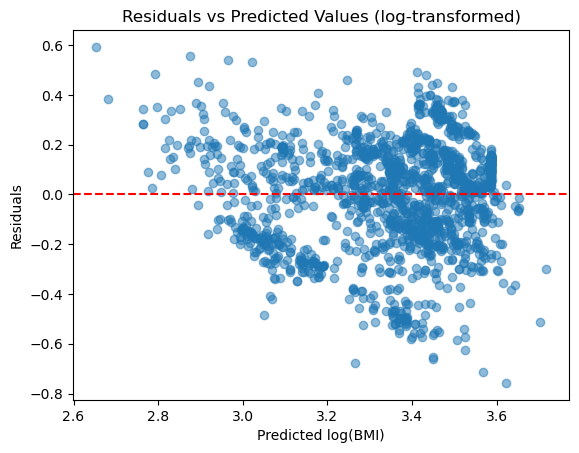

In [ ]:
y_pred_log = model_log.fittedvalues     
residuals_log = model_log.resid  
plt.scatter(y_pred_log, residuals_log, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(BMI)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values (log-transformed)")
plt.show()

## Square Root Transformation

In [ ]:
y_train_sqrt = np.sqrt(y_train)
y_test_sqrt = np.sqrt(y_test)

X_train_sm = sm.add_constant(X_train_df)
model_sqrt = sm.OLS(y_train_sqrt, X_train_sm).fit()

print(model_sqrt.summary())

                            OLS Regression Results                            
Dep. Variable:            BMI (kg/m2)   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     88.99
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          2.38e-200
Time:                        19:45:05   Log-Likelihood:                -1394.5
No. Observations:                1688   AIC:                             2821.
Df Residuals:                    1672   BIC:                             2908.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [ ]:
X_test_sm = sm.add_constant(X_test_df)
y_pred_sqrt = model_sqrt.predict(X_test_sm)

#sqrt scale
r2_sqrt = r2_score(y_test_sqrt, y_pred_sqrt)
rmse_sqrt = np.sqrt(mean_squared_error(y_test_sqrt, y_pred_sqrt))
print(f"R² (sqrt scale) = {r2_sqrt:.3f}, RMSE (sqrt scale) = {rmse_sqrt:.3f}")

#og
y_pred = y_pred_sqrt**2  # back-transform
r2_orig = r2_score(y_test, y_pred)
rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² (original BMI scale) = {r2_orig:.3f}, RMSE = {rmse_orig:.3f}")


R² (sqrt scale) = 0.342, RMSE (sqrt scale) = 0.613
R² (original BMI scale) = 0.354, RMSE = 6.550


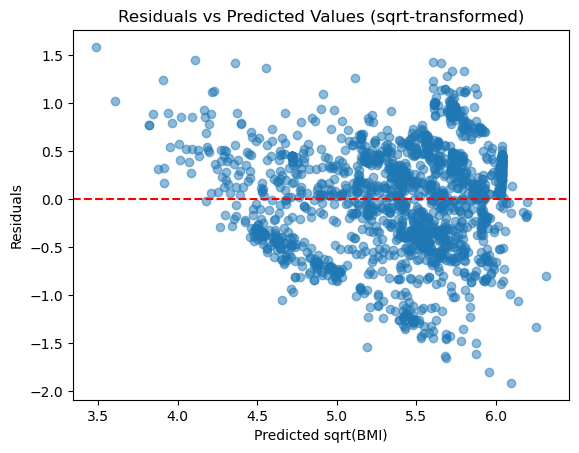

In [ ]:
residuals_sqrt = y_train_sqrt - model_sqrt.fittedvalues

# Residuals vs fitted
import matplotlib.pyplot as plt
plt.scatter(model_sqrt.fittedvalues, residuals_sqrt, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted sqrt(BMI)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values (sqrt-transformed)")
plt.show()

Neither transformation improved the residuals, and diagnostic plots indicated that the linearity assumption and constant variance of errors were not met, so a linear model is probably not the best fit. Polynomial or spline models are unlikely to help much, since most predictors are categorical. Next, we will fit a Lasso regression on the same features after standardization to improve prediction and perform feature selection.

In [ ]:
lasso_pipeline = Pipeline([
    ('preprocessor', preprocess),       
    ('scaler', StandardScaler()),       
    ('lasso', LassoCV(cv=5, random_state=42))  
])

lasso_pipeline.fit(X_train, y_train)

y_pred_lasso = lasso_pipeline.predict(X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Lasso R² = {r2_lasso:.3f}, RMSE = {rmse_lasso:.3f}")

feature_names = preprocess.get_feature_names_out()
lasso_coefs = pd.Series(lasso_pipeline.named_steps['lasso'].coef_, index=feature_names)
print("\nLasso coefficients (non-zero only):")
print(lasso_coefs[lasso_coefs != 0].sort_values(ascending=False))

Lasso R² = 0.353, RMSE = 6.556

Lasso coefficients (non-zero only):
encoder__Overweight_Family_History_Yes                    3.278796
numeric__Age                                              2.287889
encoder__Means_of_Transportation_Public Transportation    1.846173
encoder__Alcohol_Consumption_Frequency_Sometimes          1.436045
encoder__High_Calorie_Consumption_Often_Yes               0.704668
encoder__Workout_Frequency_I do not exercise              0.261689
encoder__Means_of_Transportation_Walking                  0.123020
encoder__Means_of_Transportation_Motorbike                0.007329
encoder__Workout_Frequency_3 to 4 days a week            -0.240062
encoder__Workout_Frequency_4 to 5 days a week            -0.324770
encoder__Calories_Monitored_Daily_Yes                    -0.420618
encoder__Vegetable_Consumption_Often_Never               -0.701483
encoder__Vegetable_Consumption_Often_Sometimes           -1.517636
dtype: float64


About 35% of the variance in BMI is explained by the predictors in our test set. This indicates that the strongest predictors of BMI are Family history, age, public transportation, and sometimes drinking alcohol.

Our residuals from OLS showed non-linear patterns, so we will also try using Random Forest.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state=42)

rf.fit(X_train_df, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test_df)

# Evaluate performance
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest R² = {r2_rf:.3f}, RMSE = {rmse_rf:.3f}")

# Feature importance
rf_importances = pd.Series(rf.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)
print("\nTop 10 most important features:")
print(rf_importances.head(10))


Random Forest R² = 0.657, RMSE = 4.772

Top 10 most important features:
numeric__Age                                              0.374900
encoder__Overweight_Family_History_Yes                    0.246881
encoder__Vegetable_Consumption_Often_Sometimes            0.084856
encoder__Alcohol_Consumption_Frequency_Sometimes          0.080151
encoder__Means_of_Transportation_Public Transportation    0.058530
encoder__Workout_Frequency_I do not exercise              0.035778
encoder__High_Calorie_Consumption_Often_Yes               0.031167
encoder__Workout_Frequency_3 to 4 days a week             0.027508
encoder__Workout_Frequency_4 to 5 days a week             0.020230
encoder__Vegetable_Consumption_Often_Never                0.018342
dtype: float64


The Random Forest model explained 66% of the variance in BMI (R² = 0.657) and achieved an RMSE of 4.77, indicating substantially better predictive performance than both OLS and Lasso. The most important predictors were age and family history of overweight, followed by lifestyle factors such as vegetable consumption, alcohol intake, exercise frequency, and transportation method. This suggests that Random Forest effectively captures non-linear relationships and interactions that linear models could not.

Across the three models, age and family history consistently emerged as the strongest predictors of BMI. OLS regression provided interpretable coefficients and significance tests, showing that higher age, positive family history, higher alcohol intake, lower vegetable consumption, and certain transportation methods were associated with increased BMI. Lasso regression, a regularized linear model, confirmed these main predictors while shrinking less important variables toward zero, resulting in slightly lower predictive accuracy (R² = 0.353, RMSE = 6.56). Random Forest, by capturing non-linear patterns and interactions, achieved the highest predictive accuracy (R² = 0.657, RMSE = 4.77) and highlighted the same variables as most influential, though with importance scores rather than effect sizes. Overall, the combined analysis indicates that both demographic factors (age, family history) and lifestyle behaviors (diet, alcohol, exercise, transportation) contribute meaningfully to BMI, with predictive performance improving as model flexibility increases.

## Model 2: Multiclass Logistic Regression

Which eating habits, lifestyle factors, and physical activity factors are most predictive of obesity level?

In [ ]:
df.head(5)

Gender   Age  Height (m)  Weight (kg) Overweight_Family_History  \
0  Female  21.0        1.62         64.0                       Yes   
1  Female  21.0        1.52         56.0                       Yes   
2    Male  23.0        1.80         77.0                       Yes   
3    Male  27.0        1.80         87.0                        No   
4    Male  22.0        1.78         89.8                        No   

  High_Calorie_Consumption_Often Vegetable_Consumption_Often  \
0                             No                   Sometimes   
1                             No                      Always   
2                             No                   Sometimes   
3                             No                      Always   
4                             No                   Sometimes   

   Num_Main_Meals_Daily Eat_Between_Meals Smoke_Regularly  \
0                     3         Sometimes              No   
1                     3         Sometimes             Yes   
2                     3         Sometimes              No   
3                     3         Sometimes              No   
4                     1         Sometimes              No   

        Water_Drank_Daily Calories_Monitored_Daily   Workout_Frequency  \
0  Between 1 and 2 liters                       No   I do not exercise   
1      More than 2 liters                      Yes  4 to 5 days a week   
2  Between 1 and 2 liters                       No  3 to 4 days a week   
3  Between 1 and 2 liters                       No  3 to 4 days a week   
4  Between 1 and 2 liters                       No   I do not exercise   

  Time_Using_Technology_Daily Alcohol_Consumption_Frequency  \
0                   3-5 hours                         Never   
1                   0-2 hours                     Sometimes   
2                   3-5 hours                    Frequently   
3                   0-2 hours                    Frequently   
4                   0-2 hours                     Sometimes   

  Means_of_Transportation        Obesity_Level  BMI (kg/m2)  
0   Public Transportation        Normal Weight        24.39  
1   Public Transportation        Normal Weight        24.24  
2   Public Transportation        Normal Weight        23.77  
3                 Walking   Overweight Level I        26.85  
4   Public Transportation  Overweight Level II        28.34

In [ ]:
df.columns

Index(['Gender', 'Age', 'Height (m)', 'Weight (kg)',
       'Overweight_Family_History', 'High_Calorie_Consumption_Often',
       'Vegetable_Consumption_Often', 'Num_Main_Meals_Daily',
       'Eat_Between_Meals', 'Smoke_Regularly', 'Water_Drank_Daily',
       'Calories_Monitored_Daily', 'Workout_Frequency',
       'Time_Using_Technology_Daily', 'Alcohol_Consumption_Frequency',
       'Means_of_Transportation', 'Obesity_Level', 'BMI (kg/m2)'],
      dtype='object')

In [ ]:
df['Obesity_Level'].value_counts()

Obesity_Level
Obesity Type I         351
Obesity Type III       324
Obesity Type II        297
Overweight Level I     290
Overweight Level II    290
Normal Weight          286
Insufficient Weight    272
Name: count, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

Because weight, height, and BMI are all direct components of obesity classification calculations, we will remove them from this model so that we can see the true impact of the other variables on obesity classifications.

In [ ]:
logit_df = df.drop(columns=['BMI_kg_m2', 'Height_meters', 'Weight_kg'])

In [ ]:
logit_X = logit_df[['Gender', 'Age','Overweight_Family_History', 'High_Calorie_Consumption_Often',
       'Vegetable_Consumption_Often', 'Num_Main_Meals_Daily',
       'Eat_Between_Meals', 'Smoke_Regularly', 'Water_Drank_Daily',
       'Calories_Monitored_Daily', 'Workout_Frequency',
       'Time_Using_Technology_Daily', 'Alcohol_Consumption_Frequency',
       'Means_of_Transportation']]
logit_y = logit_df['Obesity_Level']

In [ ]:
cats = ['Gender', 'Overweight_Family_History', 'High_Calorie_Consumption_Often',
       'Vegetable_Consumption_Often',
       'Eat_Between_Meals', 'Smoke_Regularly', 'Water_Drank_Daily',
       'Calories_Monitored_Daily', 'Workout_Frequency',
       'Time_Using_Technology_Daily', 'Alcohol_Consumption_Frequency',
       'Means_of_Transportation']
nums = ['Age', 'Num_Main_Meals_Daily']

In [ ]:
preprocess = ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first"), cats),
 ("numeric", StandardScaler(), nums)])

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)

In [ ]:
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logreg)
])

In [ ]:
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(
logit_X, logit_y, test_size=0.20, stratify=logit_y, random_state=42)

In [ ]:
pipe.fit(X_train_logit, y_train_logit)

/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender',
                                                   'Overweight_Family_History',
                                                   'High_Calorie_Consumption_Often',
                                                   'Vegetable_Consumption_Often',
                                                   'Eat_Between_Meals',
                                                   'Smoke_Regularly',
                                                   'Water_Drank_Daily',
                                                   'Calories_Monitored_Daily',
                                                   'Workout_Frequency',
                                                   'Time_Using_Technology_Daily',
                                                   'Alcohol_Consumption_Frequency',
                                                   'Means_of_Transportation']),
                                                 ('numeric', StandardScaler(),
                                                  ['Age',
                                                   'Num_Main_Meals_Daily'])])),
                ('model',
                 LogisticRegression(max_iter=2000, multi_class='multinomial'))])

In [ ]:
print('Training Accuracy:', pipe.score(X_train_logit, y_train_logit))
print('Testing Accuracy:', pipe.score(X_test_logit, y_test_logit))

Training Accuracy: 0.6332938388625592
Testing Accuracy: 0.6374407582938388


Our training and testing accuracy are both ~63%. The fact that they are similar indicates that our model is not overfitting. Because this is a multiclass classification problem with several classes, a ~63% accuracy is quite good.

In [ ]:
y_pred_probs = pipe.predict_proba(X_test_logit)
loss = log_loss(y_test_logit, y_pred_probs)
print('Log Loss:', loss)

Log Loss: 1.063015923164218


Our log loss of ~1.0630, for a multiclass classification problem, is fairly low compared to random predictions, indicating that our model is relatively confident and performing well.

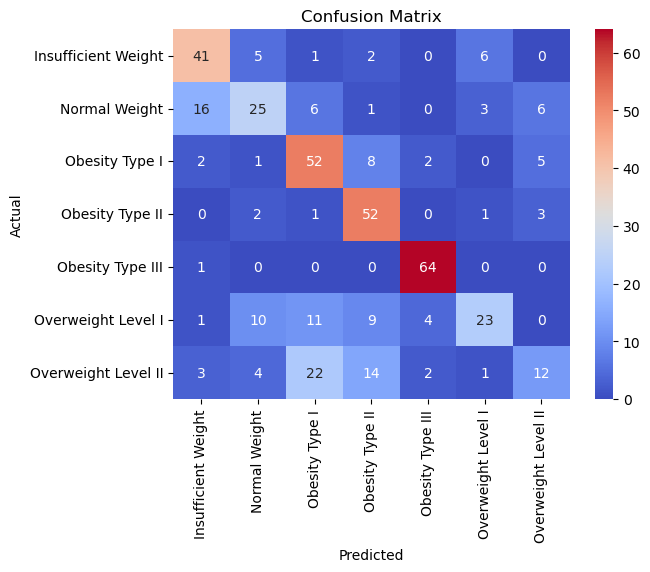

In [ ]:
y_pred_logit = pipe.predict(X_test_logit)
conf_mat = confusion_matrix(y_test_logit, y_pred_logit, labels=pipe.classes_)
sns.heatmap(conf_mat, annot=True, cmap='coolwarm', fmt='d', xticklabels=pipe.classes_, yticklabels=pipe.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix, we can see that our model does a good job of classifying Obesity Types I-III and Insufficient Weight, but performs worse when classifying Normal Weight and Overweight Levels I and II. This could be because Insufficient Weight and Obesity Types I-III are on opposite ends of the spectrum and are less easily confused, as opposed to normal versus overweight which might be harder to distinguish due to narrower margins of classifying between the two.

In [ ]:
print(classification_report(y_test_logit, y_pred_logit))

                     precision    recall  f1-score   support

Insufficient Weight       0.64      0.75      0.69        55
      Normal Weight       0.53      0.44      0.48        57
     Obesity Type I       0.56      0.74      0.64        70
    Obesity Type II       0.60      0.88      0.72        59
   Obesity Type III       0.89      0.98      0.93        65
 Overweight Level I       0.68      0.40      0.50        58
Overweight Level II       0.46      0.21      0.29        58

           accuracy                           0.64       422
          macro avg       0.62      0.63      0.61       422
       weighted avg       0.63      0.64      0.61       422



In [ ]:
roc_auc_score(y_test_logit, y_pred_probs, multi_class='ovr')

0.8878254824002871

Our ROC value of ~0.8878 means that our model is performing well, as it is fairly close to 1 (perfect model).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

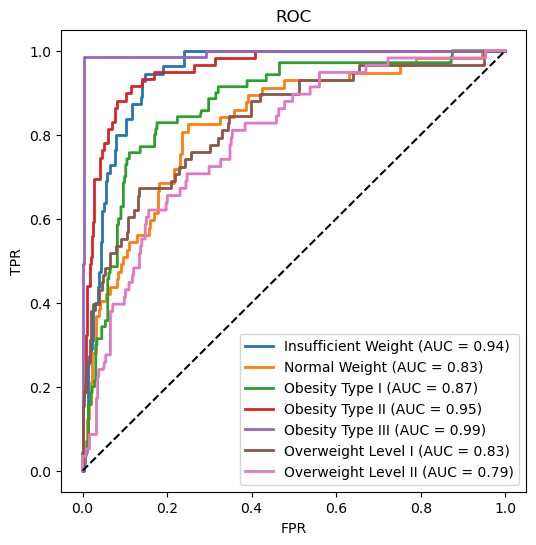

In [ ]:
y_test_bin = label_binarize(y_test_logit, classes=np.unique(y_test_logit))
n = y_test_bin.shape[1]
y_pred_probs = pipe.predict_proba(X_test_logit)

plt.figure(figsize=(6,6))
for i in range(n):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{np.unique(y_test_logit)[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(pipe, X_train_logit, y_train_logit, cv=5, scoring='accuracy')
print(f"CV Accuracy Scores: {cv}")
print(f"Mean CV Accuracy: {cv.mean():.3f}")
print(f"Standard Deviation of CV Accuracy: {cv.std():.3f}")

CV Accuracy Scores: [0.5887574  0.6183432  0.59467456 0.61721068 0.61424332]
Mean CV Accuracy: 0.607
Standard Deviation of CV Accuracy: 0.012


/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/erinsiedlecki/miniconda3/envs/ds6001/li

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc": "accuracy", "neg_log_loss": "neg_log_loss"}
cv_results = cross_validate(pipe, logit_X, logit_y, cv=cv, scoring=scoring)
cv_acc = np.mean(cv_results["test_acc"])
cv_ll = -np.mean(cv_results["test_neg_log_loss"])
print(f"Mean CV Accuracy: {cv_acc:.3f}")
print(f"Mean CV Log Loss: {cv_ll:.3f}")

/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mean CV Accuracy: 0.607
Mean CV Log Loss: 1.053


/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


The mean CV accuracy of 0.607 among folds is good for a multiclass classification. Our standard deviation of 0.012 is quite small which means the results do not change much between folds. These results indicate that our model is stable, generalizes well, and does not overfit. The mean CV log loss of 1.053 is fairly low for a seven-class classification, indicating that our model is not too overconfident and inaccurate.

## Lasso

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
import plotly.express as px

In [ ]:
lasso_clf = Pipeline(steps=[("preprocess", preprocess),
                            ("model", LogisticRegressionCV(penalty="l1", solver="saga", Cs=25, cv=5, 
                                  scoring="neg_log_loss", max_iter=8000, n_jobs=-1, multi_class='ovr'))])
lasso_clf.fit(X_train_logit, y_train_logit)
categoricals = cats
numerics = nums
encoder_names = lasso_clf.named_steps["preprocess"].named_transformers_["encoder"]
catnames = encoder_names.get_feature_names_out(categoricals)
features = np.concatenate((catnames, numerics))
lasso_model = lasso_clf.named_steps["model"]
coefs = lasso_model.coef_
coef_df = pd.DataFrame(coefs.T, index=features, columns=lasso_model.classes_)
cdf_melt = coef_df.reset_index().melt(id_vars="index", var_name="Class", value_name="Coefficient")
cdf_sort = cdf_melt.sort_values("Coefficient", ascending=False)
fig = px.bar(cdf_sort, x="Coefficient", y="index", color="Class", orientation="h", title="Lasso Coefficients by Magnitude")
fig.update_layout(yaxis={"categoryorder":"total ascending"})
fig.show()

/Users/erinsiedlecki/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1955: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Looking at the coefficient plot, we can see that "Overweight_Family_History_Yes" has a large, positive effect on classifying obesity types. Other strong, positive predictors of obesity are Means_of_Transportation_Public Transportation and Alcohol_Consumption_Frequency_Sometimes. Vegetable_Consumption_Often_Sometimes has a large, negative effect on classifying Obesity Type III. This means that individuals who eat vegetables often sometimes are less likely to be classified as Obesity Type III. Another strong, negative predictor of Obesity Type III is Gender_Male. Overall, we can see that family history, alcohol consumption, means of transportation, vegetable consumption, and gender are all strong predictors of obesity classes.

In [ ]:
top5 = 5
abs_coef = coef_df.abs()
top5_feat = {}

for cols in coef_df.columns:
    top5_feat[cols] = abs_coef[cols].sort_values(ascending=False).head(top5).index.tolist()

top5_feat_df = pd.DataFrame(top5_feat)
top5_feat_df

Insufficient Weight                      Normal Weight  \
0         Eat_Between_Meals_Frequently        Eat_Between_Meals_Sometimes   
1    Means_of_Transportation_Motorbike    Means_of_Transportation_Walking   
2  Alcohol_Consumption_Frequency_Never       Means_of_Transportation_Bike   
3      Means_of_Transportation_Walking  Means_of_Transportation_Motorbike   
4                                  Age                Smoke_Regularly_Yes   

                          Obesity Type I  \
0          Overweight_Family_History_Yes   
1     High_Calorie_Consumption_Often_Yes   
2           Calories_Monitored_Daily_Yes   
3  Vegetable_Consumption_Often_Sometimes   
4           Eat_Between_Meals_Frequently   

                        Obesity Type II  \
0                           Gender_Male   
1         Overweight_Family_History_Yes   
2  Workout_Frequency_4 to 5 days a week   
3          Eat_Between_Meals_Frequently   
4           Eat_Between_Meals_Sometimes   

                                Obesity Type III  \
0                                    Gender_Male   
1          Vegetable_Consumption_Often_Sometimes   
2                  Overweight_Family_History_Yes   
3  Means_of_Transportation_Public Transportation   
4                    Eat_Between_Meals_Sometimes   

                      Overweight Level I  \
0                Eat_Between_Meals_Never   
1           Calories_Monitored_Daily_Yes   
2           Eat_Between_Meals_Frequently   
3    Alcohol_Consumption_Frequency_Never   
4  Vegetable_Consumption_Often_Sometimes   

                     Overweight Level II  
0     High_Calorie_Consumption_Often_Yes  
1          Overweight_Family_History_Yes  
2                    Smoke_Regularly_Yes  
3            Eat_Between_Meals_Sometimes  
4  Time_Using_Technology_Daily_3-5 hours

The table above tells us which predictors are the strongest in classifying a specific weight category. Looking across the categories, we can see that the most influential predictors are related to eating between meals, means of transportation, overweight family history, gender, and calorie consumption/monitoring.

In [ ]:
lasso_test_preds = lasso_clf.predict(X_test_logit)
lasso_tr_pred = lasso_clf.predict(X_train_logit)
print('Lasso Training Accuracy:', accuracy_score(y_train_logit, lasso_tr_pred))
print('Lasso Testing Accuracy:', accuracy_score(y_test_logit, lasso_test_preds))

lasso_pred_probs = lasso_clf.predict_proba(X_test_logit)
lasso_logloss = log_loss(y_test_logit, lasso_pred_probs)
print('Lasso Log Loss', lasso_logloss)

Lasso Training Accuracy: 0.629739336492891
Lasso Testing Accuracy: 0.6184834123222749
Lasso Log Loss 1.089185376129268


Our Lasso model performs slightly worse than our first logistic regression model; however, it accounts for feature selection which makes our model more interpretable. The decrease in accuracy is not large enough to cause concern.

Looking at the performance of all the models in this analysis, the first Logistic Regression model had the lowest log loss (~1.0630) and highest test accuracy (~0.6374). That model also had a strong ROC value of ~0.8878. We concluded that our model does not overfit, and based on our CV analysis, we also see that our model is stable among folds. These measures all indicate that this was the best model we developed in this analysis for predicting obesity levels. 

However, the Lasso Regression model performed only slightly worse with a log loss of (~1.0892) and test accuracy of (~0.6185). Lasso shrinks coefficients and performs variable selection, thus making that model more interpretable. The Lasso model better answers our research question (Which eating habits, lifestyle factors, and physical activity factors are most predictive of obesity level?) as it performs variable selection, leaving only the most influential predictors in the model.

## Checking Assumptions

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Checking for Multicollinearity

vif_check = pd.DataFrame(
    preprocess.fit_transform(logit_X),
    columns = (preprocess.named_transformers_['encoder']
               .get_feature_names_out(cats).tolist() + nums)
)

vif = pd.DataFrame()
vif['predictor'] = vif_check.columns
vif['VIF'] = [variance_inflation_factor(vif_check.values, i)
              for i in range(vif_check.shape[1])]
vif[vif['VIF']>10]

predictor        VIF
7               Eat_Between_Meals_Sometimes  23.326652
18  Alcohol_Consumption_Frequency_Sometimes  16.443590

Eat_Between_Meals_Somtimes and Alcohol_Consumption_Frequency_Sometimes have VIF values greater than 10 indicating multicollinearity. However, because we did Lasso in our analysis, this is not cause for concern.

## Model 3: KNN 

In [ ]:
logit_df = df.drop(columns=['BMI_kg_m2', 'Height_meters', 'Weight_kg'])

X_knn = logit_df[['Gender', 'Age','Overweight_Family_History', 'High_Calorie_Consumption_Often',
       'Vegetable_Consumption_Often', 'Num_Main_Meals_Daily',
       'Eat_Between_Meals', 'Smoke_Regularly', 'Water_Drank_Daily',
       'Calories_Monitored_Daily', 'Workout_Frequency',
       'Time_Using_Technology_Daily', 'Alcohol_Consumption_Frequency',
       'Means_of_Transportation']]

y_knn = logit_df['Obesity_Level']

In [ ]:
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
    X_knn, y_knn, test_size=0.20, stratify=y_knn, random_state=42)

In [ ]:
categorical_features = ['Gender', 'Overweight_Family_History', 'High_Calorie_Consumption_Often',
       'Vegetable_Consumption_Often', 'Eat_Between_Meals', 'Smoke_Regularly',
       'Water_Drank_Daily', 'Calories_Monitored_Daily', 'Workout_Frequency',
       'Time_Using_Technology_Daily', 'Alcohol_Consumption_Frequency',
       'Means_of_Transportation']

numeric_features = ['Age', 'Num_Main_Meals_Daily']

In [ ]:
preprocess_knn = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ],
    remainder='drop'
)

In [ ]:
pipe_knn = Pipeline([
    ("preprocess", preprocess_knn),
    ("knn", KNeighborsClassifier(weights="distance"))  # default weights "distance" (good when classes are imbalanced)
])

In [ ]:
param_grid = {"knn__n_neighbors": list(range(1, 42, 2))}
grid = GridSearchCV(pipe_knn, param_grid, cv=5, scoring="balanced_accuracy", n_jobs=-1, return_train_score=True)
grid.fit(X_train_k, y_train_k)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'Overweight_Family_History',
                                                                          'High_Calorie_Consumption_Often',
                                                                          'Vegetable_Consumption_Often',
                                                                          'Eat_Between_Meals',
                                                                          'Smoke_Regularly',
                                                                          'Water_Drank_Daily',
                                                                          'Calories_Monitored_Daily',
                                                                          'Workout_Freque...
                                                                          'Time_Using_Technology_Daily',
                                                                          'Alcohol_Consumption_Frequency',
                                                                          'Means_of_Transportation']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Num_Main_Meals_Daily'])])),
                                       ('knn',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23, 25, 27, 29, 31, 33, 35,
                                              37, 39, 41]},
             return_train_score=True, scoring='balanced_accuracy')

In [ ]:
results_df = pd.DataFrame(grid.cv_results_)
results_df["k"] = results_df["param_knn__n_neighbors"]
results_df["mean_score"] = results_df["mean_test_score"]

best_k = grid.best_params_["knn__n_neighbors"]
best_score = grid.best_score_
print(f"Best k: {best_k}, Best CV balanced accuracy: {best_score:.3f}")


Best k: 5, Best CV balanced accuracy: 0.730


Using cross-validation, the model achieved its highest balanced accuracy at k = 5 with a CV balanced accuracy of 0.730 which indicates that this neighborhood size provides the best tradeoff between flexibility and stability. 

In [ ]:
fig = px.line(
    results_df,
    x="k",
    y="mean_score",
    title=f"Cross-Validated Balanced Accuracy vs K (best k = {best_k})",
    markers=True,
    labels={"k": "Number of Neighbors (k)", "mean_score": "Mean CV Balanced Accuracy"}
)
fig.add_scatter(
    x=[best_k],
    y=[best_score],
    mode="markers+text",
    text=[f"Best k = {best_k}"],
    textposition="top center",
    name="Best k"
)
fig.update_layout(hovermode="x unified")
fig.show()

In [ ]:
final_pipe = Pipeline([
    ("preprocess", preprocess_knn),
    ("knn", KNeighborsClassifier(n_neighbors=best_k, weights="distance"))
])

final_pipe.fit(X_train_k, y_train_k)
y_pred_k = final_pipe.predict(X_test_k)

acc = accuracy_score(y_test_k, y_pred_k)
bal_acc = balanced_accuracy_score(y_test_k, y_pred_k)
print(f"Test Accuracy: {acc:.3f}")
print(f"Test Balanced Accuracy: {bal_acc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test_k, y_pred_k))

On the held-out test test, the model performed slightly better, with an overall accuracy of 0.744 and a balanced accuracy of 0.738 which suggests that it generalizes well across classes with different sample sizes. The classification report shows strong recall for the more easily separable obesity classes, especially Obesity Type III (recall of 0.98) and Obesity Type II (recall of 0.86). The performance on Normal Weight is the weakest (recall of 0.32), which reflects overlap with other categories. 

In [ ]:
conf_mat = confusion_matrix(y_test_k, y_pred_k, labels=final_pipe.named_steps["knn"].classes_)
cm_df = pd.DataFrame(conf_mat, index=final_pipe.named_steps["knn"].classes_, columns=final_pipe.named_steps["knn"].classes_)
print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
                     Insufficient Weight  Normal Weight  Obesity Type I  \
Insufficient Weight                   47              2               0   
Normal Weight                         10             18               8   
Obesity Type I                         0              2              55   
Obesity Type II                        0              1               1   
Obesity Type III                       0              1               0   
Overweight Level I                     3              5               5   
Overweight Level II                    3              2               8   

                     Obesity Type II  Obesity Type III  Overweight Level I  \
Insufficient Weight                4                 0                   1   
Normal Weight                      5                 0                   5   
Obesity Type I                     4                 1                   3   
Obesity Type II                   51                 0               

This confusion matrix reinforces what we found before where misclassifications cluster mainly among adjacent weight categories, whereas more extreme classes (like Obesity Type III and Insufficient Weight) are recognized with high consistency.

Overall this model provides reliable multi-class performance, especially for the clinically significant higher-risk obesity classes. 

## Model 4: K Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
df.head()

Gender   Age  Height (m)  Weight (kg) Overweight_Family_History  \
0  Female  21.0        1.62         64.0                       Yes   
1  Female  21.0        1.52         56.0                       Yes   
2    Male  23.0        1.80         77.0                       Yes   
3    Male  27.0        1.80         87.0                        No   
4    Male  22.0        1.78         89.8                        No   

  High_Calorie_Consumption_Often Vegetable_Consumption_Often  \
0                             No                   Sometimes   
1                             No                      Always   
2                             No                   Sometimes   
3                             No                      Always   
4                             No                   Sometimes   

   Num_Main_Meals_Daily Eat_Between_Meals Smoke_Regularly  \
0                     3         Sometimes              No   
1                     3         Sometimes             Yes   
2                     3         Sometimes              No   
3                     3         Sometimes              No   
4                     1         Sometimes              No   

        Water_Drank_Daily Calories_Monitored_Daily   Workout_Frequency  \
0  Between 1 and 2 liters                       No   I do not exercise   
1      More than 2 liters                      Yes  4 to 5 days a week   
2  Between 1 and 2 liters                       No  3 to 4 days a week   
3  Between 1 and 2 liters                       No  3 to 4 days a week   
4  Between 1 and 2 liters                       No   I do not exercise   

  Time_Using_Technology_Daily Alcohol_Consumption_Frequency  \
0                   3-5 hours                         Never   
1                   0-2 hours                     Sometimes   
2                   3-5 hours                    Frequently   
3                   0-2 hours                    Frequently   
4                   0-2 hours                     Sometimes   

  Means_of_Transportation        Obesity_Level  BMI (kg/m2)  
0   Public Transportation        Normal Weight        24.39  
1   Public Transportation        Normal Weight        24.24  
2   Public Transportation        Normal Weight        23.77  
3                 Walking   Overweight Level I        26.85  
4   Public Transportation  Overweight Level II        28.34

In [ ]:
numeric = df[['Age', 'Height_meters', 'Weight_kg', 'Num_Main_Meals_Daily', 'BMI_kg_m2']]

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, init='k-means++', n_init=10))
])

### Elbow Method

In [ ]:
K_values = list(range(1,15))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(numeric)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)

fig = px.line(
    x = K_values,
    y = wcss,
    markers = True,
    title = 'Elbow Plot (Pipeline: StandardScaler + KMeans)',
    labels = {'x': 'Number of Clusters (k)', 'y': 'WCSS / Inertia'}
)

fig.show()

In [ ]:
elbow = numeric.copy()
pipe.set_params(kmeans__n_clusters=4)
pipe.fit(elbow)
labels = pipe['kmeans'].labels_

In [ ]:
elbow['cluster'] = labels.astype(str)
elbow

Age  Height (m)  Weight (kg)  Num_Main_Meals_Daily  BMI (kg/m2)  \
0     21.000000    1.620000    64.000000                     3        24.39   
1     21.000000    1.520000    56.000000                     3        24.24   
2     23.000000    1.800000    77.000000                     3        23.77   
3     27.000000    1.800000    87.000000                     3        26.85   
4     22.000000    1.780000    89.800000                     1        28.34   
...         ...         ...          ...                   ...          ...   
2106  20.976842    1.710730   131.408528                     3        44.90   
2107  21.982942    1.748584   133.742943                     3        43.74   
2108  22.524036    1.752206   133.689352                     3        43.54   
2109  24.361936    1.739450   133.346641                     3        44.07   
2110  23.664709    1.738836   133.472641                     3        44.14   

     cluster  
0          3  
1          3  
2          3  
3          3  
4          2  
...      ...  
2106       1  
2107       1  
2108       1  
2109       1  
2110       1  

[2111 rows x 6 columns]

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Age by Cluster (Elbow Method)", "Height_meters by Cluster (Elbow Method)", "Weight_kg by Cluster (Elbow Method)", "Num_Main_Meals_Daily by Cluster (Elbow Method)"))

for i, col in enumerate(elbow.drop(['cluster', 'BMI_kg_m2'], axis=1).columns):
    fig.add_trace(
        go.Violin(x=elbow['cluster'], y=elbow[col], box_visible=True),
        row=(i // 2) + 1, col=(i % 2) + 1
    )

fig.update_layout(height=800, showlegend=False)
fig.show()

In [ ]:
px.violin(elbow, x="cluster", y="BMI_kg_m2", box=True, title="BMI_kg_m2 by Cluster (Elbow Method)")

### Silhouette Scores

In [ ]:
sil_scores = []
K_values_sil = list(range(2,15))

for k in K_values_sil:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(numeric)

    labels = pipe['kmeans'].labels_

    sil = silhouette_score(numeric, labels)
    sil_scores.append(sil)

fig = px.line(
    x = K_values_sil,
    y = sil_scores,
    markers = True,
    title = 'Silhouette Scores (Pipeline: StandardScaler + KMeans)',
    labels = {'x': 'Number of Clusters (k)', 'y': 'Silhouette Score'}
)

fig.show()

In [ ]:
silhouette = numeric.copy()
pipe.set_params(kmeans__n_clusters=2)
pipe.fit(silhouette)
labels = pipe['kmeans'].labels_

In [ ]:
silhouette['cluster'] = labels.astype(str)
silhouette

Age  Height (m)  Weight (kg)  Num_Main_Meals_Daily  BMI (kg/m2)  \
0     21.000000    1.620000    64.000000                     3        24.39   
1     21.000000    1.520000    56.000000                     3        24.24   
2     23.000000    1.800000    77.000000                     3        23.77   
3     27.000000    1.800000    87.000000                     3        26.85   
4     22.000000    1.780000    89.800000                     1        28.34   
...         ...         ...          ...                   ...          ...   
2106  20.976842    1.710730   131.408528                     3        44.90   
2107  21.982942    1.748584   133.742943                     3        43.74   
2108  22.524036    1.752206   133.689352                     3        43.54   
2109  24.361936    1.739450   133.346641                     3        44.07   
2110  23.664709    1.738836   133.472641                     3        44.14   

     cluster  
0          1  
1          1  
2          1  
3          0  
4          1  
...      ...  
2106       0  
2107       0  
2108       0  
2109       0  
2110       0  

[2111 rows x 6 columns]

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Age by Cluster (Silhouette Score)", "Height_meters by Cluster (Silhouette Score)", "Weight_kg by Cluster (Silhouette Score)", "Num_Main_Meals_Daily by Cluster (Silhouette Score)"))

for i, col in enumerate(silhouette.drop(['cluster', 'BMI_kg_m2'], axis=1).columns):
    fig.add_trace(
        go.Violin(x=silhouette['cluster'], y=silhouette[col], box_visible=True),
        row=(i // 2) + 1, col=(i % 2) + 1
    )

fig.update_layout(height=800, showlegend=False)
fig.show()

In [ ]:
px.violin(silhouette, x="cluster", y="BMI_kg_m2", box=True, title="BMI_kg_m2 by Cluster (Silhouette Score)")

## K Modes Clustering

K Modes available from "conda install kmodes"

Citation:
@Misc{devos2015,
  author = {Nelis J. de Vos},
  title = {kmodes categorical clustering library},
  howpublished = {\url{https://github.com/nicodv/kmodes}},
  year = {2015--2024}
}

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
categorical = df.select_dtypes(include='object')

In [ ]:
K_values = list(range(1,10))
costs = []

for k in K_values:
    km = KModes(n_clusters=k, init='Huang')
    clusters = km.fit_predict(categorical)
    cost = km.cost_
    costs.append(cost)

fig = px.line(
    x = K_values,
    y = costs,
    markers = True,
    title = 'Elbow Plot (KModes)',
    labels = {'x': 'Number of Clusters (k)', 'y': 'Cost'}
)

fig.show()

In [ ]:
km = KModes(n_clusters=2, init='Huang')
clusters = km.fit_predict(categorical)

In [ ]:
kmod = categorical.copy()
kmod['cluster'] = clusters.astype(str)
kmod

Gender Overweight_Family_History High_Calorie_Consumption_Often  \
0     Female                       Yes                             No   
1     Female                       Yes                             No   
2       Male                       Yes                             No   
3       Male                        No                             No   
4       Male                        No                             No   
...      ...                       ...                            ...   
2106  Female                       Yes                            Yes   
2107  Female                       Yes                            Yes   
2108  Female                       Yes                            Yes   
2109  Female                       Yes                            Yes   
2110  Female                       Yes                            Yes   

     Vegetable_Consumption_Often Eat_Between_Meals Smoke_Regularly  \
0                      Sometimes         Sometimes              No   
1                         Always         Sometimes             Yes   
2                      Sometimes         Sometimes              No   
3                         Always         Sometimes              No   
4                      Sometimes         Sometimes              No   
...                          ...               ...             ...   
2106                      Always         Sometimes              No   
2107                      Always         Sometimes              No   
2108                      Always         Sometimes              No   
2109                      Always         Sometimes              No   
2110                      Always         Sometimes              No   

           Water_Drank_Daily Calories_Monitored_Daily   Workout_Frequency  \
0     Between 1 and 2 liters                       No   I do not exercise   
1         More than 2 liters                      Yes  4 to 5 days a week   
2     Between 1 and 2 liters                       No  3 to 4 days a week   
3     Between 1 and 2 liters                       No  3 to 4 days a week   
4     Between 1 and 2 liters                       No   I do not exercise   
...                      ...                      ...                 ...   
2106  Between 1 and 2 liters                       No  3 to 4 days a week   
2107  Between 1 and 2 liters                       No  1 or 2 days a week   
2108  Between 1 and 2 liters                       No  1 or 2 days a week   
2109      More than 2 liters                       No  1 or 2 days a week   
2110      More than 2 liters                       No  1 or 2 days a week   

     Time_Using_Technology_Daily Alcohol_Consumption_Frequency  \
0                      3-5 hours                         Never   
1                      0-2 hours                     Sometimes   
2                      3-5 hours                    Frequently   
3                      0-2 hours                    Frequently   
4                      0-2 hours                     Sometimes   
...                          ...                           ...   
2106                   3-5 hours                     Sometimes   
2107                   3-5 hours                     Sometimes   
2108                   3-5 hours                     Sometimes   
2109                   3-5 hours                     Sometimes   
2110                   3-5 hours                     Sometimes   

     Means_of_Transportation        Obesity_Level cluster  
0      Public Transportation        Normal Weight       0  
1      Public Transportation        Normal Weight       0  
2      Public Transportation        Normal Weight       1  
3                    Walking   Overweight Level I       1  
4      Public Transportation  Overweight Level II       1  
...                      ...                  ...     ...  
2106   Public Transportation     Obesity Type III       0  
2107   Public Transportation     Obesity Type III       0  
2108   Public Transportation  

In [ ]:
print(km.cluster_centroids_)

[['Female' 'Yes' 'Yes' 'Always' 'Sometimes' 'No' 'Between 1 and 2 liters'
  'No' 'I do not exercise' '3-5 hours' 'Sometimes'
  'Public Transportation' 'Obesity Type III']
 ['Male' 'Yes' 'Yes' 'Sometimes' 'Sometimes' 'No'
  'Between 1 and 2 liters' 'No' '1 or 2 days a week' '0-2 hours'
  'Sometimes' 'Public Transportation' 'Obesity Type II']]


In [ ]:
centroids = pd.DataFrame(km.cluster_centroids_)
centroids.columns = [df.select_dtypes(include='object').columns]
centroids.T

0                       1
Gender                                          Female                    Male
Overweight_Family_History                          Yes                     Yes
High_Calorie_Consumption_Often                     Yes                     Yes
Vegetable_Consumption_Often                     Always               Sometimes
Eat_Between_Meals                            Sometimes               Sometimes
Smoke_Regularly                                     No                      No
Water_Drank_Daily               Between 1 and 2 liters  Between 1 and 2 liters
Calories_Monitored_Daily                            No                      No
Workout_Frequency                    I do not exercise      1 or 2 days a week
Time_Using_Technology_Daily                  3-5 hours               0-2 hours
Alcohol_Consumption_Frequency                Sometimes               Sometimes
Means_of_Transportation          Public Transportation   Public Transportation
Obesity_Level                         Obesity Type III         Obesity Type II

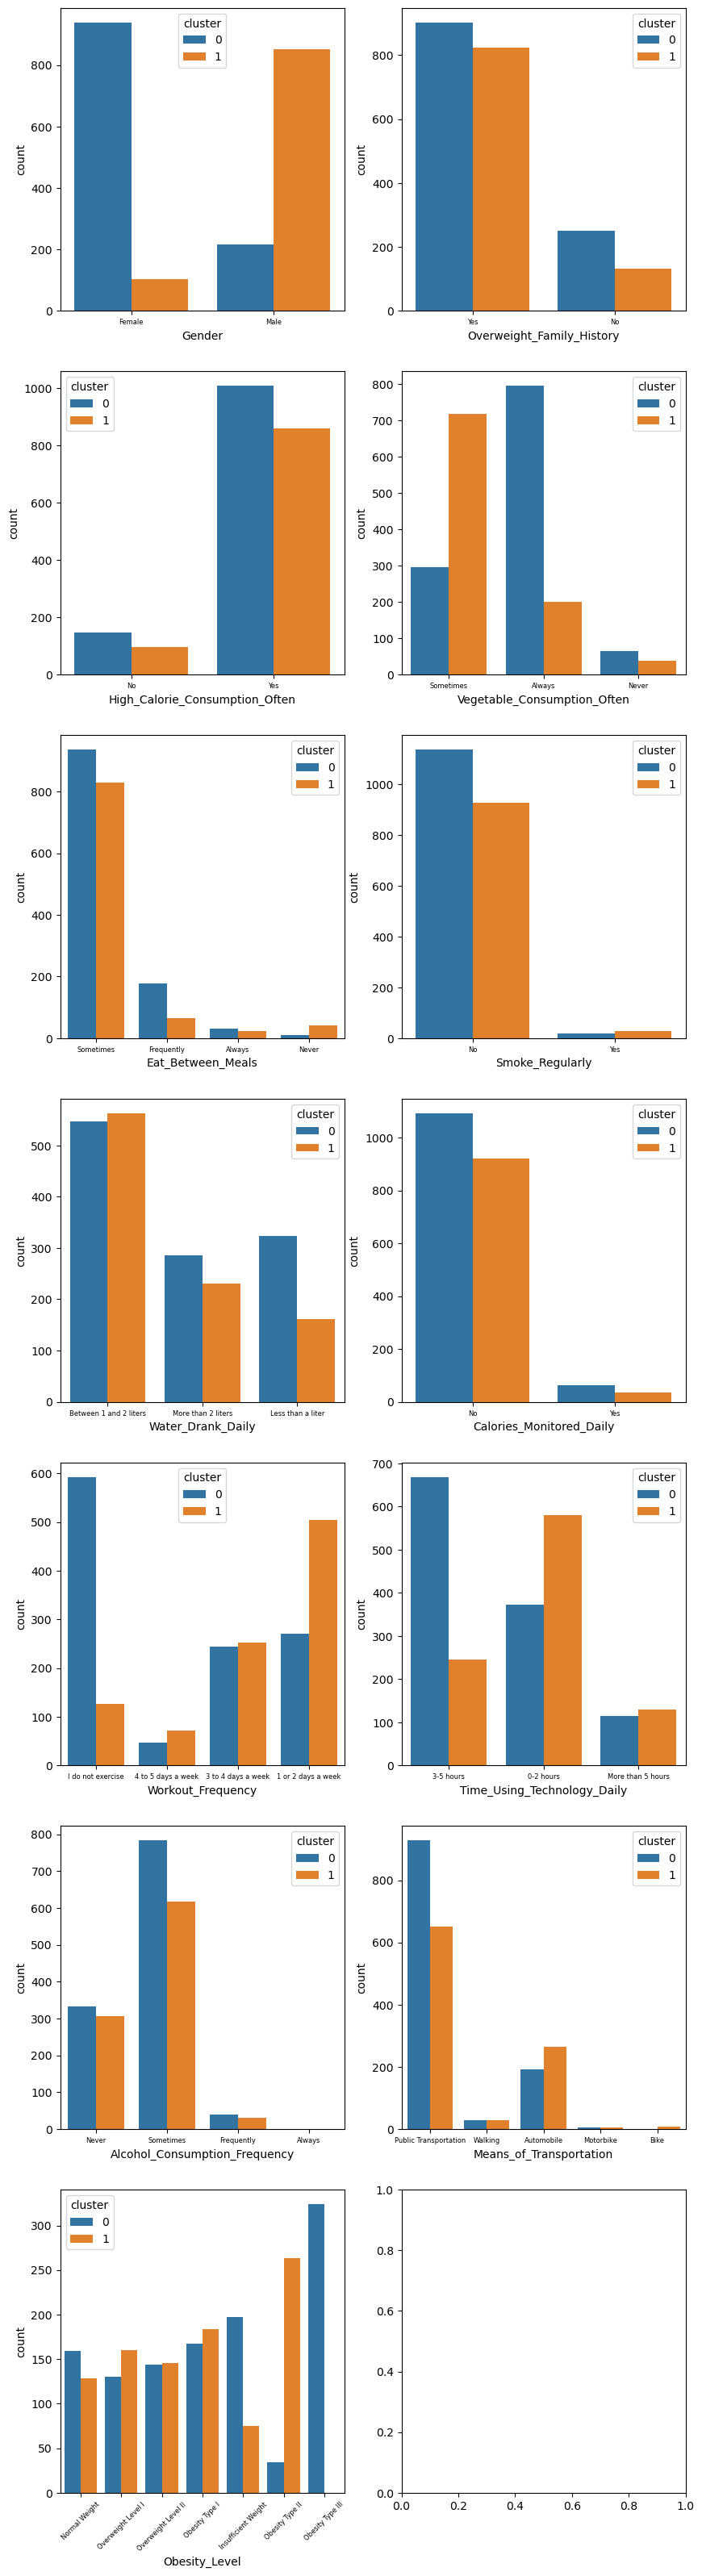

In [ ]:
fig, axes = plt.subplots(7, 2, figsize=(10, 40))

for i, col in enumerate(kmod.drop('cluster', axis=1).columns):
    g = sns.countplot(x=col, hue='cluster', data=kmod, ax=axes[i//2, i%2])
    axes[i//2, i%2].tick_params(axis='x', labelsize=6)

axes[6,0].tick_params(axis='x', rotation=45)

plt.show()

## K Prototype Clustering

In [ ]:
from kmodes.kprototypes import KPrototypes

In [ ]:
kproto = df.copy()

In [ ]:
K_values = list(range(1,8))
costs = []

for k in K_values:
    kp = KPrototypes(n_clusters=k, init='Huang')
    clusters = kp.fit_predict(kproto, categorical=[df.columns.get_loc(col) for col in df.select_dtypes(include='object').columns])
    cost = kp.cost_
    costs.append(cost)

fig = px.line(
    x = K_values,
    y = costs,
    markers = True,
    title = 'Elbow Plot (KPrototypes)',
    labels = {'x': 'Number of Clusters (k)', 'y': 'Cost'}
)

fig.show()

In [ ]:
kp = KPrototypes(n_clusters=2, init='Huang')
clusters = kp.fit_predict(kproto, categorical=[df.columns.get_loc(col) for col in df.select_dtypes(include='object').columns])

In [ ]:
kproto['cluster'] = clusters.astype(str)
kproto

Gender        Age  Height (m)  Weight (kg) Overweight_Family_History  \
0     Female  21.000000    1.620000    64.000000                       Yes   
1     Female  21.000000    1.520000    56.000000                       Yes   
2       Male  23.000000    1.800000    77.000000                       Yes   
3       Male  27.000000    1.800000    87.000000                        No   
4       Male  22.000000    1.780000    89.800000                        No   
...      ...        ...         ...          ...                       ...   
2106  Female  20.976842    1.710730   131.408528                       Yes   
2107  Female  21.982942    1.748584   133.742943                       Yes   
2108  Female  22.524036    1.752206   133.689352                       Yes   
2109  Female  24.361936    1.739450   133.346641                       Yes   
2110  Female  23.664709    1.738836   133.472641                       Yes   

     High_Calorie_Consumption_Often Vegetable_Consumption_Often  \
0                                No                   Sometimes   
1                                No                      Always   
2                                No                   Sometimes   
3                                No                      Always   
4                                No                   Sometimes   
...                             ...                         ...   
2106                            Yes                      Always   
2107                            Yes                      Always   
2108                            Yes                      Always   
2109                            Yes                      Always   
2110                            Yes                      Always   

      Num_Main_Meals_Daily Eat_Between_Meals Smoke_Regularly  \
0                        3         Sometimes              No   
1                        3         Sometimes             Yes   
2                        3         Sometimes              No   
3                        3         Sometimes              No   
4                        1         Sometimes              No   
...                    ...               ...             ...   
2106                     3         Sometimes              No   
2107                     3         Sometimes              No   
2108                     3         Sometimes              No   
2109                     3         Sometimes              No   
2110                     3         Sometimes              No   

           Water_Drank_Daily Calories_Monitored_Daily   Workout_Frequency  \
0     Between 1 and 2 liters                       No   I do not exercise   
1         More than 2 liters                      Yes  4 to 5 days a week   
2     Between 1 and 2 liters                       No  3 to 4 days a week   
3     Between 1 and 2 liters                       No  3 to 4 days a week   
4     Between 1 and 2 liters                       No   I do not exercise   
...                      ...                      ...                 ...   
2106  Between 1 and 2 liters                       No  3 to 4 days a week   
2107  Between 1 and 2 liters                       No  1 or 2 days a week   
2108  Between 1 and 2 liters                       No  1 or 2 days a week   
2109      More than 2 liters                       No  1 or 2 days a week   
2110      More than 2 liters                       No  1 or 2 days a week   

     Time_Using_Technology_Daily Alcohol_Consumption_Frequency  \
0                      3-5 hours                         Never   
1                      0-2 hours                     Sometimes   
2                      3-5 hours                    Frequently   
3                      0-2 hours                    Frequently   
4                      0-2 hours                     Sometimes   
...                          ...                           ...   
2106                   3-5 hours                     Sometimes   
2107                   3-5 hours          

In [ ]:
print(kp.cluster_centroids_)

[['25.433391856796167' '1.7427234150485438' '114.2713585449027'
  '2.804611650485437' '37.7331796116506' 'Male' 'Yes' 'Yes' 'Always'
  'Sometimes' 'No' 'Between 1 and 2 liters' 'No' '1 or 2 days a week'
  '3-5 hours' 'Sometimes' 'Public Transportation' 'Obesity Type III']
 ['23.5950143877234' '1.6753976682206706' '68.86058217871022'
  '2.613053613053613' '24.556993006993036' 'Female' 'Yes' 'Yes'
  'Sometimes' 'Sometimes' 'No' 'Between 1 and 2 liters' 'No'
  '1 or 2 days a week' '0-2 hours' 'Sometimes' 'Public Transportation'
  'Overweight Level I']]


In [ ]:
centroids = pd.DataFrame(kp.cluster_centroids_)
centroids.columns = ['Age', 'Height_meters', 'Weight_kg', 'Num_Main_Meals_Daily', 'BMI_kg_m2', 
                     'Gender', 'Overweight_Family_History', 'High_Calorie_Consumption_Often',
                     'Vegetable_Consumption_Often', 'Eat_Between_Meals', 'Smoke_Regularly',
                     'Water_Drank_Daily', 'Calories_Monitored_Daily', 'Workout_Frequency',
                     'Time_Using_Technology_Daily', 'Alcohol_Consumption_Frequency',
                     'Means_of_Transportation', 'Obesity_Level']
centroids.T

0                       1
Age                                 25.433391856796167        23.5950143877234
Height (m)                          1.7427234150485438      1.6753976682206706
Weight (kg)                          114.2713585449027       68.86058217871022
Num_Main_Meals_Daily                 2.804611650485437       2.613053613053613
BMI (kg/m2)                           37.7331796116506      24.556993006993036
Gender                                            Male                  Female
Overweight_Family_History                          Yes                     Yes
High_Calorie_Consumption_Often                     Yes                     Yes
Vegetable_Consumption_Often                     Always               Sometimes
Eat_Between_Meals                            Sometimes               Sometimes
Smoke_Regularly                                     No                      No
Water_Drank_Daily               Between 1 and 2 liters  Between 1 and 2 liters
Calories_Monitored_Daily                            No                      No
Workout_Frequency                   1 or 2 days a week      1 or 2 days a week
Time_Using_Technology_Daily                  3-5 hours               0-2 hours
Alcohol_Consumption_Frequency                Sometimes               Sometimes
Means_of_Transportation          Public Transportation   Public Transportation
Obesity_Level                         Obesity Type III      Overweight Level I

# Principle Component Analysis

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
df = pd.read_csv('obesity_cleaned.csv')

In [ ]:
# one hot encode categorical features
enc = OneHotEncoder(drop='first')
encoded = enc.fit_transform(df[['Gender', 
                                'Overweight_Family_History',
                                'High_Calorie_Consumption_Often',
                                'Vegetable_Consumption_Often',
                                'Eat_Between_Meals',
                                'Smoke_Regularly',
                                'Water_Drank_Daily',
                                'Calories_Monitored_Daily',
                                'Workout_Frequency',
                                'Time_Using_Technology_Daily',
                                'Alcohol_Consumption_Frequency',
                                'Means_of_Transportation',
                                'Obesity_Level']]).toarray()

In [ ]:
cat_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(['Gender',
                                                                  'Overweight_Family_History',
                                                                  'High_Calorie_Consumption_Often',
                                                                  'Vegetable_Consumption_Often',
                                                                  'Eat_Between_Meals',
                                                                  'Smoke_Regularly',
                                                                  'Water_Drank_Daily',
                                                                  'Calories_Monitored_Daily',
                                                                  'Workout_Frequency',
                                                                  'Time_Using_Technology_Daily',
                                                                  'Alcohol_Consumption_Frequency',
                                                                  'Means_of_Transportation',
                                                                  'Obesity_Level']))

numeric_df = df.select_dtypes(include=[float, int])
pca_df = pd.concat([numeric_df, cat_df], axis=1)

In [ ]:
X = pca_df[['Age', 'Height', 'Weight', 'Num_Main_Meals_Daily', 'Gender_Male', 'BMI_kg_m2',
       'Overweight_Family_History_Yes', 'High_Calorie_Consumption_Often_Yes',
       'Vegetable_Consumption_Often_Never',
       'Vegetable_Consumption_Often_Sometimes', 'Eat_Between_Meals_Frequently',
       'Eat_Between_Meals_Never', 'Eat_Between_Meals_Sometimes',
       'Smoke_Regularly_Yes', 'Water_Drank_Daily_Less than a liter',
       'Water_Drank_Daily_More than 2 liters', 'Calories_Monitored_Daily_Yes',
       'Workout_Frequency_3 to 4 days a week',
       'Workout_Frequency_4 to 5 days a week',
       'Workout_Frequency_I do not exercise',
       'Time_Using_Technology_Daily_3-5 hours',
       'Time_Using_Technology_Daily_More than 5 hours',
       'Alcohol_Consumption_Frequency_Frequently',
       'Alcohol_Consumption_Frequency_Never',
       'Alcohol_Consumption_Frequency_Sometimes',
       'Means_of_Transportation_Bike', 'Means_of_Transportation_Motorbike',
       'Means_of_Transportation_Public Transportation',
       'Means_of_Transportation_Walking'
]]

In [ ]:
pca_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA())
])

pca_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [ ]:
# NOTE: may not need

corr_X = X.corr()

fig_corr_X = px.imshow(
    corr_X,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Matrix of Predictors"
)
fig_corr_X.update_layout(
    width=900,
    height=900,
)
fig_corr_X.show()

In [ ]:
pca_model = pca_pipe.named_steps["pca"]
explained_var = pca_model.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)
n_components = len(explained_var)

ev_df = pd.DataFrame({
    "PC": np.arange(1, n_components + 1),
    "ExplainedVariance": explained_var,
    "CumulativeVariance": cum_explained_var
})


fig_scree = px.line(
    ev_df, x="PC", y="ExplainedVariance",
    markers=True,
    title="Scree Plot: Proportion of Variance Explained"
)
fig_scree.show()

The first PC explaining only 13% of the variance in the data is a result of high-dimensional, so while the first three PCs do not explain much of the variance, the elbow method on the scree plot suggests that we use three PCs for our analysis.

## Trying a simpler way
leaning toward going w/ this one

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_df)

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

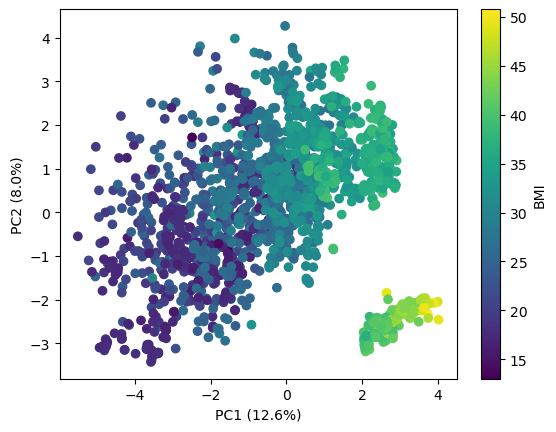

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=df['BMI_kg_m2'],
    cmap='viridis'
)

plt.xlabel('PC1 ({:.1f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 ({:.1f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.colorbar(label='BMI')
plt.show()

PC1 is likely capturing BMI-relevant variation
- low BMI cluster in left/center
- high BMI cluster in right/upper-right
- when checking our loadings, we see that the following are the biggest contributors to PC1:
    - weight
    - sometimes eat between meals
    - overweight family history
    - obesity level type III
    - often high calorie consumption

PC2 does not seem to be strongly related to BMI
- no clear pattern in the vertical direction
- no clustering between high/low points - intermingled
- the following variables contributed to PC2 the most:
    - male gender
    - often/sometimes consume vegetables
    - height
    - never consume alcohol
    - age

We do see a small yellow cluster in the corner of the plot that likely represents a subgroup of high-BMI individuals who have similar lifestyles and differ more strongly from the rest of the sampled population.

The low explained variance is due to data with high-dimensionality and is a result of sampling lifestyle survey data which is often messy because it is measuring human behavior. This does not mean that the PCA is bad, but rather that BMI is influenced by many independent factors.

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1','PC2','PC3'],
    index=pca_df.columns
)

loadings.sort_values('PC1', ascending=False)

PC1       PC2       PC3
Weight                                         0.430192  0.022482  0.063397
BMI (kg/m2)                                    0.416757 -0.077000 -0.095681
Eat_Between_Meals_Sometimes                    0.298189  0.134383 -0.168218
Overweight_Family_History_Yes                  0.275389  0.158494 -0.124201
Obesity_Level_Obesity Type III                 0.267847 -0.380517 -0.046457
High_Calorie_Consumption_Often_Yes             0.189944  0.007474 -0.015380
Obesity_Level_Obesity Type II                  0.187859  0.199377  0.152736
Alcohol_Consumption_Frequency_Sometimes        0.187624 -0.260834  0.276707
Height                                         0.178399  0.271581  0.399621
Age                                            0.121631  0.205337 -0.213865
Water_Drank_Daily_More than 2 liters           0.087099 -0.044596  0.076724
Time_Using_Technology_Daily_3-5 hours          0.066312 -0.134358  0.102511
Num_Main_Meals_Daily                           0.062283 -0.021197  0.254144
Obesity_Level_Obesity Type I                   0.051775  0.168448 -0.259138
Gender_Male                                    0.050023  0.411016  0.293336
Workout_Frequency_I do not exercise            0.030959 -0.178800 -0.362007
Means_of_Transportation_Public Transportation  0.020723 -0.282402  0.065617
Smoke_Regularly_Yes                           -0.006824  0.045018  0.059413
Workout_Frequency_3 to 4 days a week          -0.013707  0.044576  0.230050
Obesity_Level_Overweight Level II             -0.018583  0.159019 -0.133823
Means_of_Transportation_Bike                  -0.020874  0.048655  0.050274
Vegetable_Consumption_Often_Never             -0.036249 -0.049198  0.077618
Means_of_Transportation_Motorbike             -0.041131  0.019081 -0.002717
Alcohol_Consumption_Frequency_Frequently      -0.053674  0.076770  0.024245
Vegetable_Consumption_Often_Sometimes         -0.069142  0.298637 -0.054864
Obesity_Level_Overweight Level I              -0.076856 -0.020677  0.080989
Time_Using_Technology_Daily_More than 5 hours -0.077806  0.107785 -0.068649
Water_Drank_Daily_Less than a liter           -0.078419 -0.089808 -0.144841
Eat_Between_Meals_Never                       -0.086677 -0.050434  0.129947
Workout_Frequency_4 to 5 days a week          -0.088626  0.115281  0.065439
Means_of_Transportation_Walking               -0.092537  0.073024  0.077991
Calories_Monitored_Daily_Yes                  -0.144573 -0.078488  0.060189
Alcohol_Consumption_Frequency_Never           -0.171122  0.237694 -0.294400
Obesity_Level_Normal Weight                   -0.232470 -0.036695  0.134318
Eat_Between_Meals_Frequently                  -0.266786 -0.132287  0.107170

In [ ]:
# function to create biplots
def biplot(scores, loadings, feature_names, pc_x=0, pc_y=1, topN=5):
    plt.figure(figsize=(10, 8))

    plt.scatter(scores[:, pc_x], scores[:, pc_y], alpha=0.6)

    loading_strength = np.sqrt(loadings[:, pc_x]**2 + loadings[:, pc_y]**2)
    top_features = np.argsort(loading_strength)[-topN:]

    for i in top_features:
        plt.arrow(0, 0,
                  loadings[i, pc_x]*5,
                  loadings[i, pc_y]*5,
                  color='red',
                  alpha=0.75)
        plt.text(loadings[i, pc_x]*5 * 1.15,
                 loadings[i, pc_y]*5 * 1.15,
                 feature_names[i],
                 color='red',
                 ha='center',
                 va='center',
                 fontsize=13)
        
    plt.xlabel(f'PC{pc_x+1} ({pca.explained_variance_ratio_[pc_x]*100:.1f}% variance)')
    plt.ylabel(f'PC{pc_y+1} ({pca.explained_variance_ratio_[pc_y]*100:.1f}% variance)')
    plt.title(f'PCA Biplot: PC{pc_x+1} vs PC{pc_y+1} (Top {topN} Features)')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

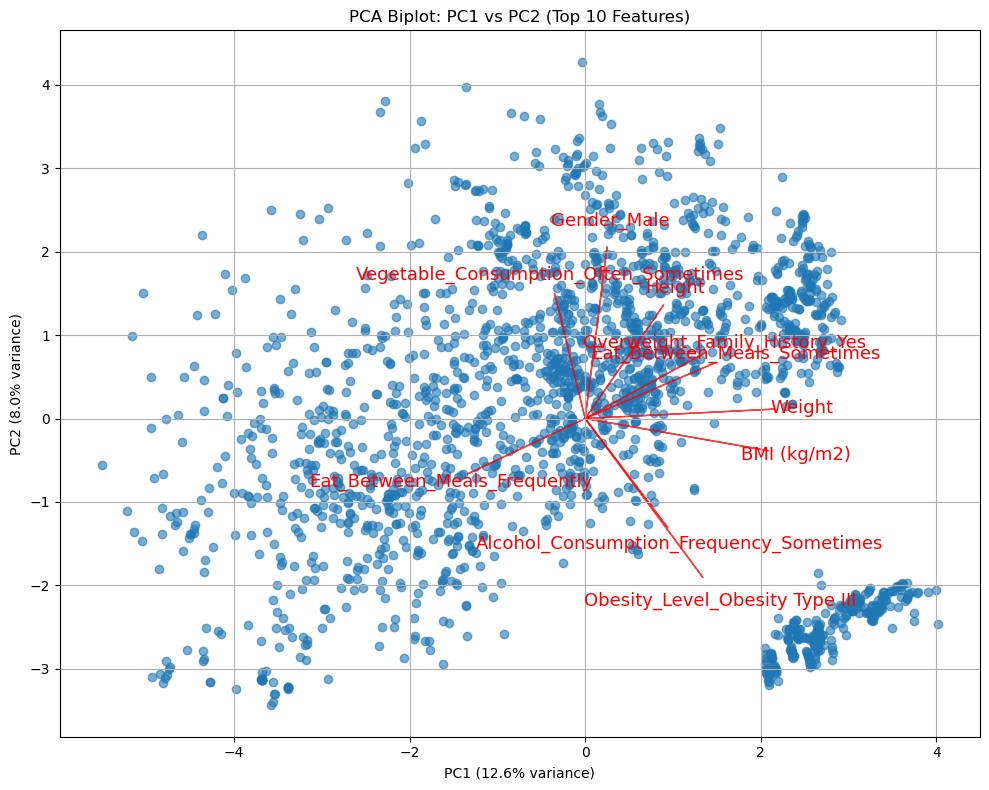

In [ ]:
loadings_df = pca.components_.T

biplot(
    scores=X_pca,
    loadings=loadings_df,
    feature_names=pca_df.columns,
    pc_x=0, 
    pc_y=1,
    topN=10
)

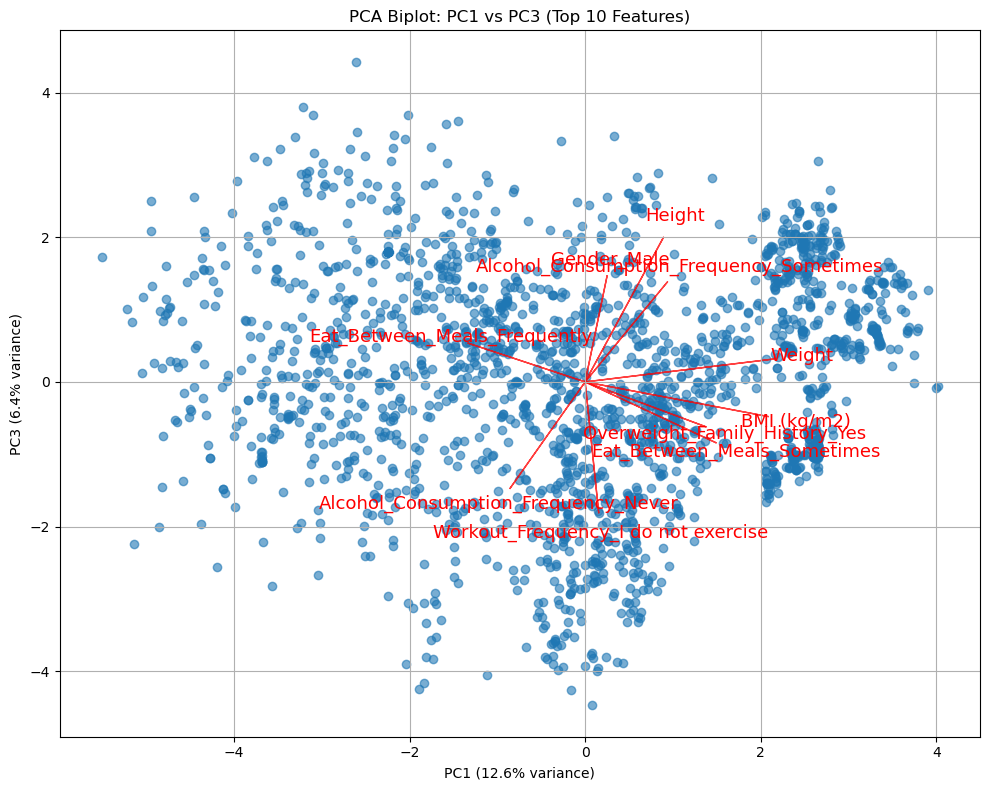

In [ ]:
biplot(
    scores=X_pca,
    loadings=loadings_df,
    feature_names=pca_df.columns,
    pc_x=0, 
    pc_y=2,
    topN=10
)

We can see here that PC1 is still dominated by the same variables

The arrows likely cluster in the center and overlap because PC3 has very small loadings, but it appears to be influenced by different lifestyle variables; however, these features do not strongly separate people along PC3.

## More complicated way - Prince

In [ ]:
X_pca_scores = pca_pipe.transform(X)
pc_cols = [f"PC{i}" for i in range(1, n_components + 1)]

scores_df = pd.DataFrame(X_pca_scores, columns=pc_cols)

In [ ]:
# NOTE: pretty unhelfpul - maybe remove and just insert scores_df instead ??
corr_PC = scores_df.corr()

fig_corr_PC = px.imshow(
    corr_PC,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Matrix of Principal Components"
)
fig_corr_PC.update_layout(
    width=800,
    height=800,
)
fig_corr_PC.show()

In [ ]:
y = pca_df['BMI_kg_m2']

In [ ]:
X_pca_scores = pca_pipe.transform(X)
pc_cols = [f"PC{i}" for i in range(1, n_components + 1)]

scores_df = pd.DataFrame(X_pca_scores, columns=pc_cols)
scores_df["BMI_kg_m2"] = y

In [ ]:
loadings = pca_model.components_.T[:, :2]
loading_df = pd.DataFrame(
    loadings,
    index=X.columns,
    columns=["PC1_loading", "PC2_loading"]
)

In [ ]:
scores_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.587199 -0.012592  1.634598  1.713937  0.515786  0.621498  0.613826   
1 -2.138378 -0.357184 -0.826275 -2.039835  0.587570  4.129403  2.897471   
2 -0.573030  2.459472 -1.467329  0.879534 -1.015750  0.940565 -0.526498   
3 -1.530886  3.540216 -1.064626 -1.766616 -2.832671  2.020148  2.509508   
4 -0.545377 -0.315418  0.108905 -1.449464  1.242749 -0.871288  0.327620   

        PC8       PC9      PC10  ...      PC21      PC22      PC23      PC24  \
0 -0.938497 -0.022366 -1.067185  ...  0.194525  0.468348  0.446239  0.261603   
1  1.524157  3.727424 -2.266968  ...  0.736879 -0.873416  0.817903  1.073171   
2 -0.869445  3.425900 -1.623204  ...  0.494341 -0.225640  0.660407  0.676847   
3 -0.641187  3.291915 -0.535644  ... -1.785114 -1.463065 -0.980715  0.218404   
4 -1.167226  0.356603 -1.207237  ... -1.041609  0.482986 -0.757013  0.996353   

       PC25      PC26      PC27      PC28      PC29  BMI (kg/m2)  
0 -0.460483  0.433146  0.041040  0.048207 -0.006223        24.39  
1  0.484434 -0.753429  0.175828  0.069943 -0.011202        24.24  
2  0.087060  0.497426  0.139375 -0.037462 -0.004130        23.77  
3  0.497425  0.572957  0.298292 -0.023219  0.019865        26.85  
4 -0.879792  0.253853  0.055617 -0.083261 -0.001873        28.34  

[5 rows x 30 columns]

In [ ]:
arrow_scale = 3

fig = go.Figure()


fig.add_trace(go.Scatter(
    x=scores_df["PC1"],
    y=scores_df["PC2"],
    mode="markers+text",
    text=scores_df["BMI_kg_m2"],
    textposition="top center",
    name="PC1",
    hovertext=[f"{t}, Points={p}" for t, p in zip(scores_df["BMI_kg_m2"], scores_df["PC1"])],
    hoverinfo="text"
))


for var_name, row in loading_df.iterrows():
    x_arrow = row["PC1_loading"] * arrow_scale
    y_arrow = row["PC2_loading"] * arrow_scale


    fig.add_trace(go.Scatter(
        x=[0, x_arrow],
        y=[0, y_arrow],
        mode="lines+markers+text",
        text=[None, var_name],
        textposition="top center",
        showlegend=False
    ))

fig.update_layout(
    title="PCA Biplot: PC1 vs PC2 with Variable Directions",
    xaxis_title="PC1",
    yaxis_title="PC2",
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True),
    width=800,
    height=700
)

fig.show()

In [ ]:
pca = pca_pipe.named_steps["pca"]

scores = pca_pipe.transform(X)
pc1 = scores[:, 0]
pc2 = scores[:, 1]


score_scaler = StandardScaler()
scores_std = score_scaler.fit_transform(np.column_stack([pc1, pc2]))

pc1_std = scores_std[:, 0]
pc2_std = scores_std[:, 1]

scores_df = pd.DataFrame({
    "PC1_std": pc1_std,
    "PC2_std": pc2_std
})


# team_col = pca_df.select_dtypes(exclude=['number']).columns[0]
# scores_df["Team"] = pca_df[team_col]

if "BMI_kg_m2" in pca_df.columns:
    scores_df["BMI_kg_m2"] = pca_df["BMI_kg_m2"]


loadings = pca.components_.T

loading_pc1 = loadings[:, 0]
loading_pc2 = loadings[:, 1]


loading_scaler = StandardScaler()
load_std = loading_scaler.fit_transform(
    np.column_stack([loading_pc1, loading_pc2])
)

loading_pc1_std = load_std[:, 0]
loading_pc2_std = load_std[:, 1]

loading_df = pd.DataFrame({
    "var": X.columns,
    "PC1_std": loading_pc1_std,
    "PC2_std": loading_pc2_std
})


In [ ]:
# PC1 vs PC2
arrow_scale = 1.8


fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=scores_df["PC1_std"],
#     y=scores_df["PC2_std"],
#     mode="markers+text",
#     text=scores_df["Team"],
#     textposition="top center",
#     name="Teams",
#     marker=dict(size=8, color="blue")
# ))


for i, row in loading_df.iterrows():
    fig.add_trace(go.Scatter(
        x=[0, row["PC1_std"] * arrow_scale],
        y=[0, row["PC2_std"] * arrow_scale],
        mode="lines+markers+text",
        text=[None, row["var"]],
        textposition="top center",
        line=dict(color="red"),
        marker=dict(size=5, color="red"),
        showlegend=False
    ))


fig.update_layout(
    title="Standardized PCA Biplot: PC1 vs PC2 (Plotly)",
    xaxis_title="PC1 (standardized)",
    yaxis_title="PC2 (standardized)",
    width=900,
    height=800,
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True),
)

fig.show()

In [ ]:
pca = pca_pipe.named_steps["pca"]

scores = pca_pipe.transform(X)
pc1 = scores[:, 0]
pc3 = scores[:, 2]


score_scaler = StandardScaler()
scores_std = score_scaler.fit_transform(np.column_stack([pc1, pc3]))

pc1_std = scores_std[:, 0]
pc3_std = scores_std[:, 1]

scores_df = pd.DataFrame({
    "PC1_std": pc1_std,
    "PC3_std": pc3_std
})


# team_col = pca_df.select_dtypes(exclude=['number']).columns[0]
# scores_df["Team"] = pca_df[team_col]


loadings = pca.components_.T

loading_pc1 = loadings[:, 0]
loading_pc3 = loadings[:, 2]


loading_scaler = StandardScaler()
load_std = loading_scaler.fit_transform(
    np.column_stack([loading_pc1, loading_pc3])
)

loading_pc1_std = load_std[:, 0]
loading_pc3_std = load_std[:, 1]

loading_df = pd.DataFrame({
    "var": X.columns,
    "PC1_std": loading_pc1_std,
    "PC3_std": loading_pc3_std
})



In [ ]:
# pc1 vs pc3 biplot

arrow_scale = 1.8


fig = go.Figure()


# fig.add_trace(go.Scatter(
#     x=scores_df["PC1_std"],
#     y=scores_df["PC3_std"],
#     mode="markers+text",
#     text=scores_df["Team"],
#     textposition="top center",
#     name="Teams",
#     marker=dict(size=8, color="blue")
# ))


for i, row in loading_df.iterrows():
    fig.add_trace(go.Scatter(
        x=[0, row["PC1_std"] * arrow_scale],
        y=[0, row["PC3_std"] * arrow_scale],
        mode="lines+markers+text",
        text=[None, row["var"]],
        textposition="top center",
        line=dict(color="red"),
        marker=dict(size=5, color="red"),
        showlegend=False
    ))


fig.update_layout(
    title="Standardized PCA Biplot: PC1 vs PC3 (Plotly)",
    xaxis_title="PC1 (standardized)",
    yaxis_title="PC3 (standardized)",
    width=900,
    height=800,
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True)
)

fig.show()